# MNIST Corrupted

## Bayesian convolutional neural network

In [48]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop

tfd = tfp.distributions
tfpl = tfp.layers
#from tensorflow_probability.layers import Convolution2DReparameterization
# If you would like to make further imports from tensorflow, add them here
#from tfpl.util import default_mean_field_normal_fn

In [49]:
# Function to load training and testing data, with labels in integer and one-hot form

def load_data(name):
    data_dir = os.path.join('data', name)
    
    x_test  = 1 - np.load(os.path.join(data_dir, 'test_images.npy')) / 255.
    x_test = x_test.astype(np.float32)
    y_test  = np.load(os.path.join(data_dir, 'test_labels.npy'))
    if len(y_test.shape) == 1:
        y_test = y_test[..., np.newaxis]    
    y_test_oh = tf.keras.utils.to_categorical(y_test)    
            
    x_train = 1 - np.load(os.path.join(data_dir, 'train_images.npy')) / 255.
    x_train = x_train.astype(np.float32)
    y_train = np.load(os.path.join(data_dir, 'train_labels.npy'))
    if len(y_train.shape) == 1:
        y_train = y_train[..., np.newaxis]     
    y_train_oh = tf.keras.utils.to_categorical(y_train)
  
    return (x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh)

In [50]:
# Function to inspect dataset digits

def inspect_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, ..., 0], cmap='gray')
        ax[i].axis('off')
    plt.show()

In [51]:
corruption_modes = ['brightness',
 'glass_blur', 
 'scale',
 'stripe',
 'canny_edges',
 'identity', 
 'shear',
 'translate',
 'dotted_line',
 'impulse_noise',
 'motion_blur',
 'shot_noise',
 'zigzag',
 'fog', 
 'rotate',
 'spatter']

In [52]:
x_c_train, y_c_train, y_c_train_oh, x_c_test, y_c_test, y_c_test_oh = dict(),dict(),dict(),dict(),dict(),dict()

In [53]:
# Load and inspect the MNIST-C dataset
for mode in corruption_modes:
    (x_c_train[mode], y_c_train[mode], y_c_train_oh[mode]), (x_c_test[mode], y_c_test[mode], y_c_test_oh[mode]) = load_data(mode) 

brightness


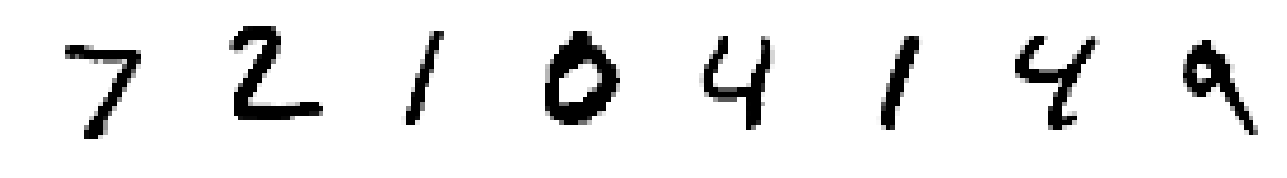

glass_blur


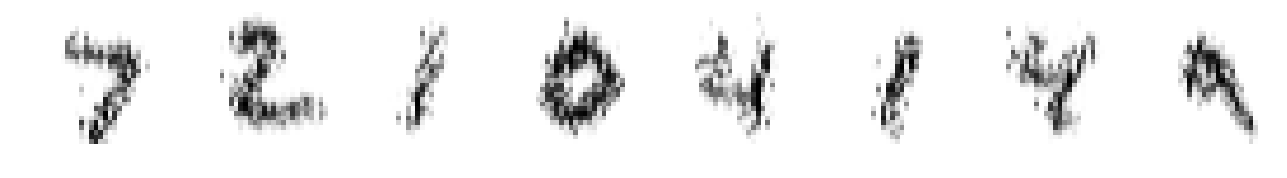

scale


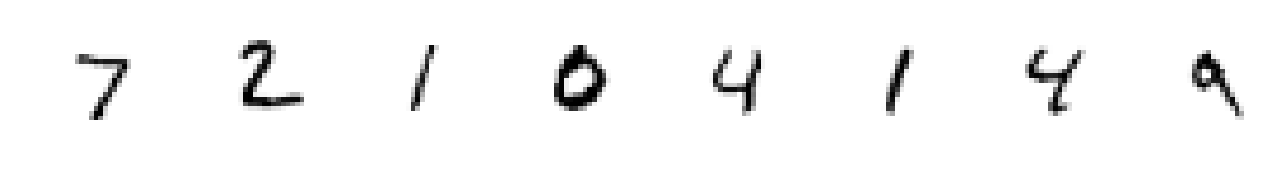

stripe


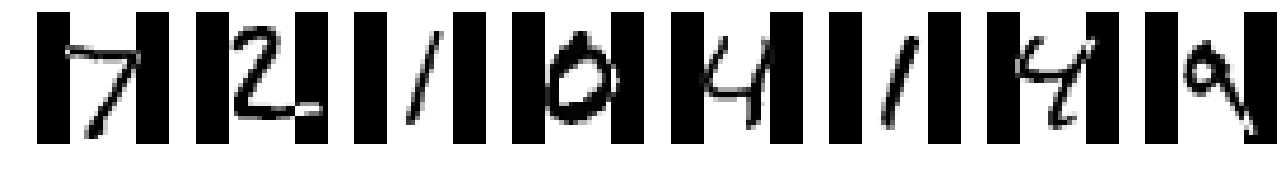

canny_edges


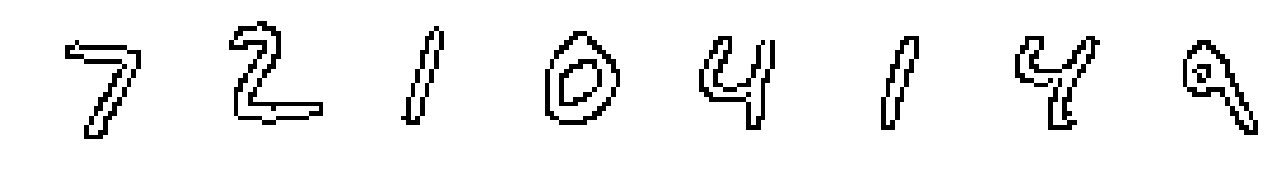

identity


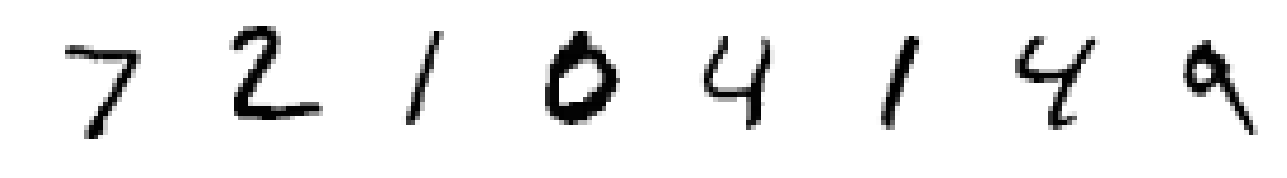

shear


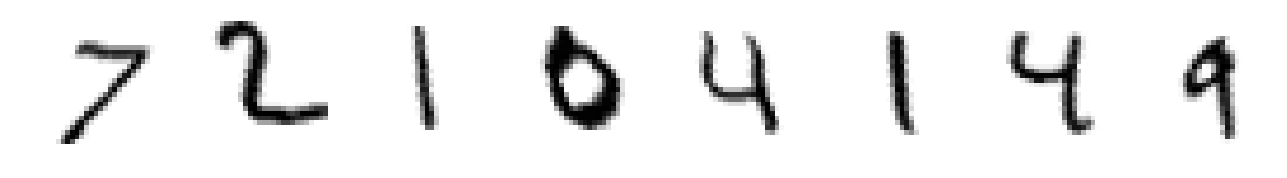

translate


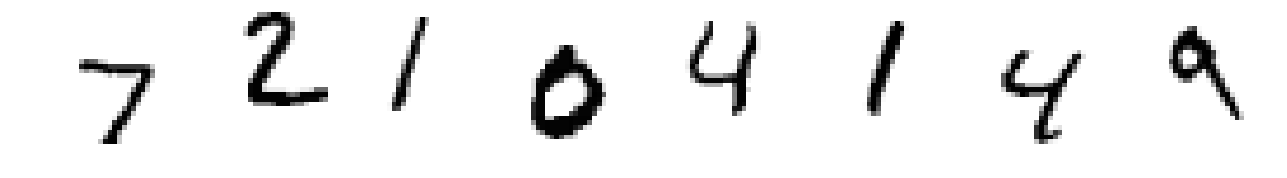

dotted_line


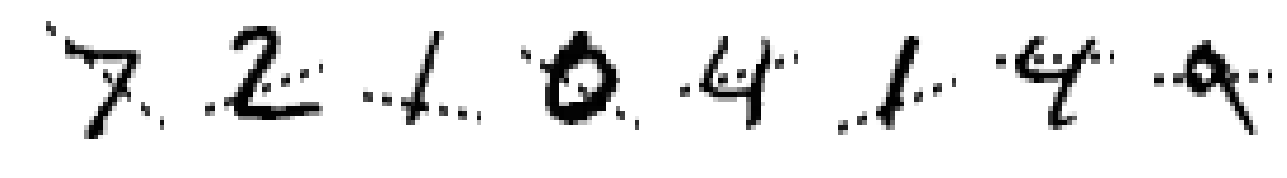

impulse_noise


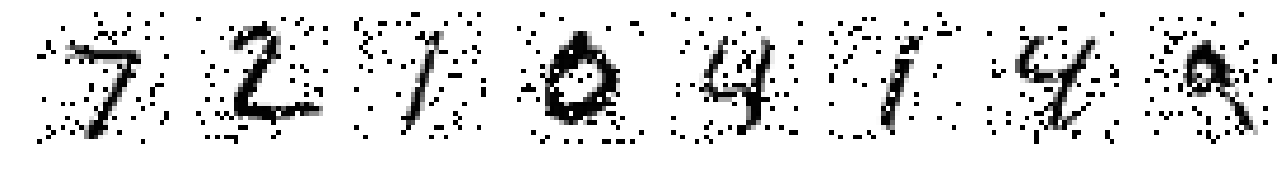

motion_blur


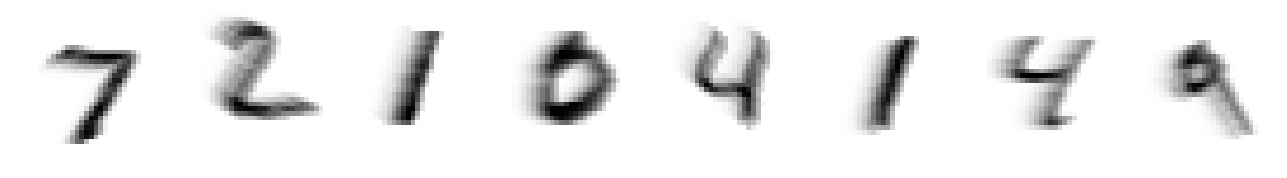

shot_noise


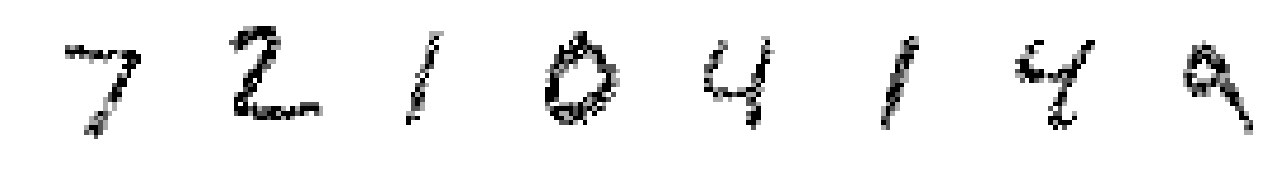

zigzag


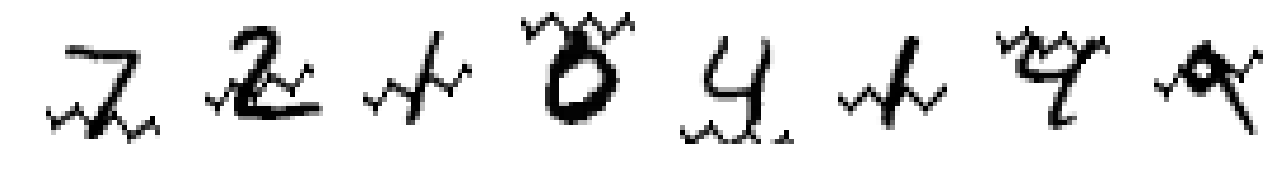

fog


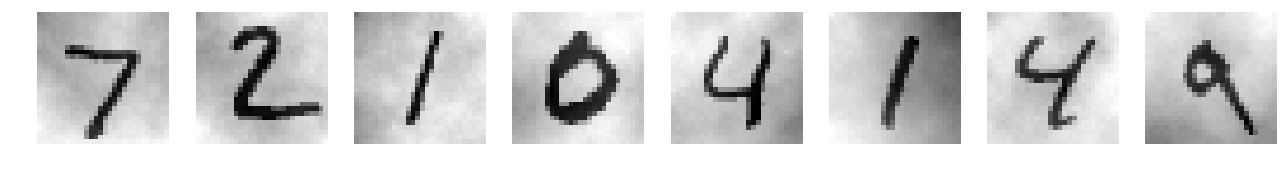

rotate


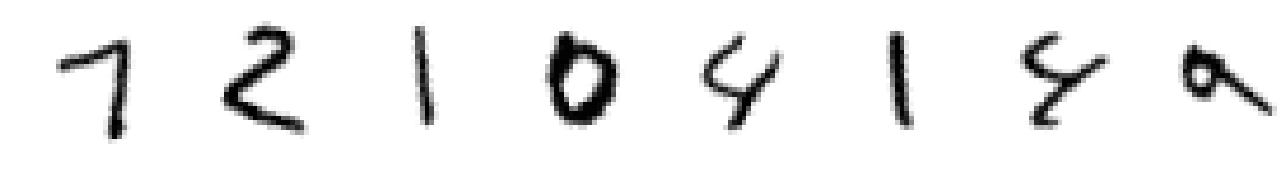

spatter


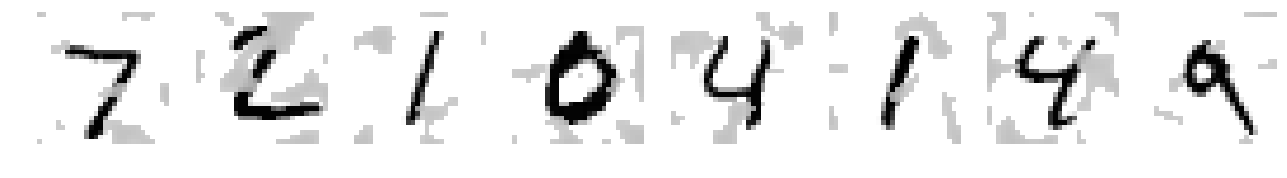

In [54]:
for mode in corruption_modes:
    print(mode)
    inspect_images(x_c_test[mode], 8)

In [55]:
def concatenate_np(x_c_train):
    x_train = np.concatenate([x_c_train[mode] for mode in corruption_modes])
    np.random.seed(2)
    np.random.shuffle(x_train) 
    return x_train

In [56]:
x_train = concatenate_np(x_c_train)
y_train = concatenate_np(y_c_train)

In [57]:
y_train_oh = concatenate_np(y_c_train_oh)

### Probabilistic CNN model

You'll start by turning this deterministic network into a probabilistic one, by letting the model output a distribution instead of a deterministic tensor. This model will capture the aleatoric uncertainty on the image labels. You will do this by adding a probabilistic layer to the end of the model and training using the negative loglikelihood. 

You should first define the negative loss likelihood loss function below. This function has arguments `y_true` for the correct label (as a one-hot vector), and `y_pred` as the model prediction (a `OneHotCategorical` distribution). It should return the negative log-likelihood of each sample in `y_true` given the predicted distribution `y_pred`. If `y_true` is of shape `[B, E]` and `y_pred` has batch shape `[B]` and event shape `[E]`, the output should be a Tensor of shape `[B]`.

In [58]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)
    """
    This function should return the negative log-likelihood of each sample
    in y_true given the predicted distribution y_pred. If y_true is of shape 
    [B, E] and y_pred has batch shape [B] and event_shape [E], the output 
    should be a Tensor of shape [B].
    """ 

In [59]:
def get_probabilistic_model(input_shape, loss, optimizer, metrics):
    """
    This function should return the probabilistic model according to the 
    above specification.
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    
    model = Sequential([
        Conv2D(8,(5,5), input_shape = input_shape, activation='relu',padding='valid'),
        MaxPooling2D(6),
        Flatten(),
        Dense(tfpl.OneHotCategorical.params_size(10)),
        tfpl.OneHotCategorical([10], convert_to_tensor_fn=tfd.Distribution.mode),
        
    ])
    model.compile(optimizer = optimizer, metrics=metrics, loss=loss)
    return model

tf.random.set_seed(0)
probabilistic_model = get_probabilistic_model(
    input_shape=(28, 28, 1), 
    loss=nll, 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

probabilistic_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 10), (None, 10))  0         
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


In [60]:
probabilistic_model.fit(x_train, y_train_oh, epochs=5)

Train on 960000 samples
Epoch 1/5
    32/960000 [..............................] - ETA: 1:27:15 - loss: 2.3346 - accuracy: 0.1562

2025-03-07 21:45:59.509046: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 3010560000 exceeds 10% of system memory.


960000/960000 [==============================] - 60s 62us/sample - loss: 0.3647 - accuracy: 0.8975
Epoch 2/5
960000/960000 [==============================] - 60s 63us/sample - loss: 0.2776 - accuracy: 0.9219
Epoch 3/5
960000/960000 [==============================] - 61s 64us/sample - loss: 0.2645 - accuracy: 0.9259
Epoch 4/5
960000/960000 [==============================] - 59s 61us/sample - loss: 0.2561 - accuracy: 0.9280
Epoch 5/5
960000/960000 [==============================] - 65s 68us/sample - loss: 0.2517 - accuracy: 0.9290


In [61]:
for mode in corruption_modes:
    print('Accuracy on corrupted MNIST test set: ', mode,
      str(probabilistic_model.evaluate(x_c_test[mode], y_c_test_oh[mode], verbose=False)[1]))

Accuracy on corrupted MNIST test set:  brightness 0.9741
Accuracy on corrupted MNIST test set:  glass_blur 0.9078
Accuracy on corrupted MNIST test set:  scale 0.9474
Accuracy on corrupted MNIST test set:  stripe 0.9511
Accuracy on corrupted MNIST test set:  canny_edges 0.9204
Accuracy on corrupted MNIST test set:  identity 0.9767
Accuracy on corrupted MNIST test set:  shear 0.947
Accuracy on corrupted MNIST test set:  translate 0.7604
Accuracy on corrupted MNIST test set:  dotted_line 0.9667
Accuracy on corrupted MNIST test set:  impulse_noise 0.9331
Accuracy on corrupted MNIST test set:  motion_blur 0.942
Accuracy on corrupted MNIST test set:  shot_noise 0.9544
Accuracy on corrupted MNIST test set:  zigzag 0.9402
Accuracy on corrupted MNIST test set:  fog 0.9574
Accuracy on corrupted MNIST test set:  rotate 0.8899
Accuracy on corrupted MNIST test set:  spatter 0.9592


#### Analyse the model predictions

We will now do some deeper analysis by looking at the probabilities the model assigns to each class instead of its single prediction. 

The function below will be useful to help us analyse the probabilistic model predictions.

In [62]:
# Function to make plots of the probabilities that the model estimates for an image

def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    for mode in corruption_modes:
        print(mode)
        if run_ensemble:
            ensemble_size = 200
        else:
            ensemble_size = 1
        image = data[mode][image_num]
        true_label = true_labels[mode][image_num, 0]
        predicted_probabilities = np.empty(shape=(ensemble_size, 10))
        for i in range(ensemble_size):
            predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
        model_prediction = model(image[np.newaxis, :])
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                    gridspec_kw={'width_ratios': [2, 4]})
        
        # Show the image and the true label
        ax1.imshow(image[..., 0], cmap='gray')
        ax1.axis('off')
        ax1.set_title('True label: {}'.format(str(true_label)))
        
        # Show a 95% prediction interval of model predicted probabilities
        pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
        pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])    
        bar = ax2.bar(np.arange(10), pct_97p5, color='red')
        bar[int(true_label)].set_color('green')
        ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
        ax2.set_xticks(np.arange(10))
        ax2.set_ylim([0, 1])
        ax2.set_ylabel('Probability')
        ax2.set_title('Model estimated probabilities')
        plt.show()

brightness


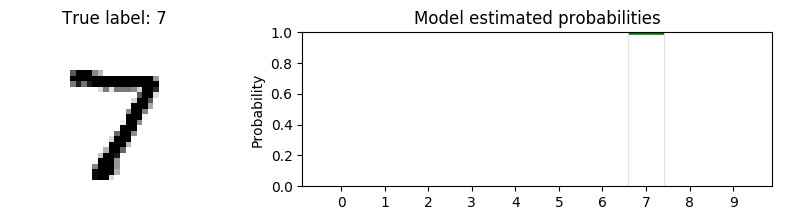

glass_blur


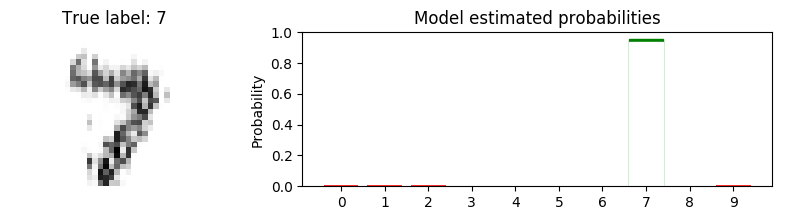

scale


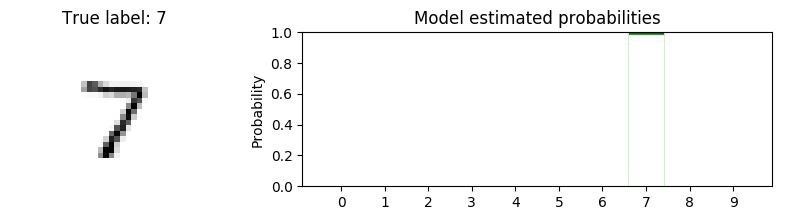

stripe


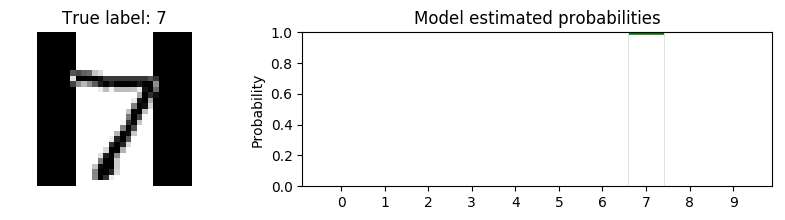

canny_edges


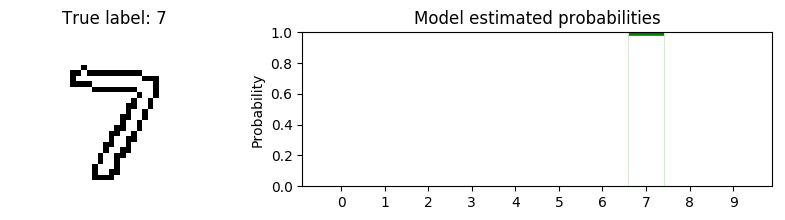

identity


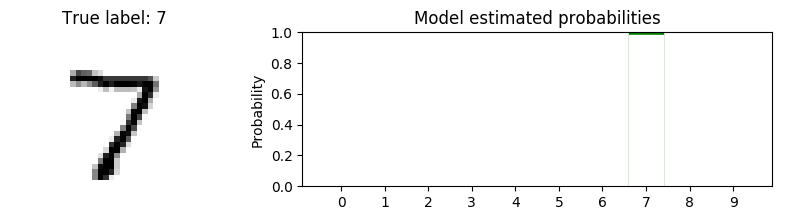

shear


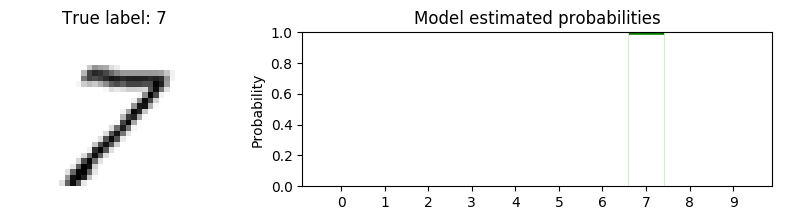

translate


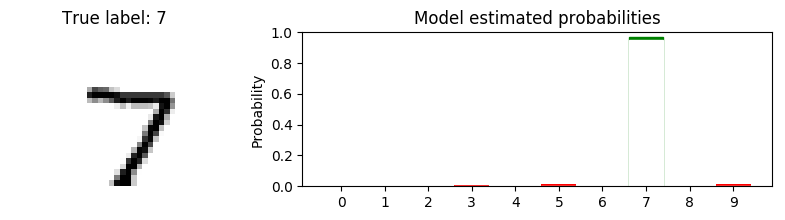

dotted_line


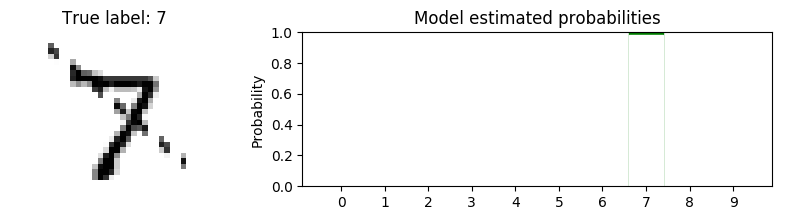

impulse_noise


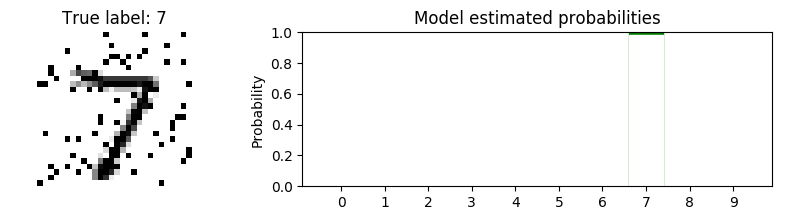

motion_blur


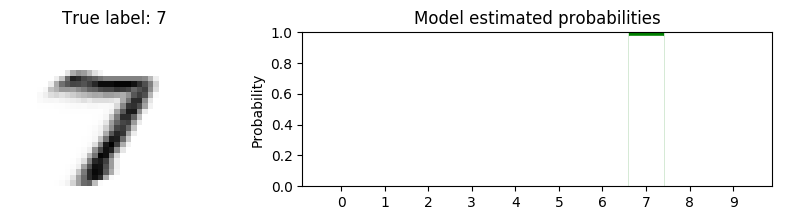

shot_noise


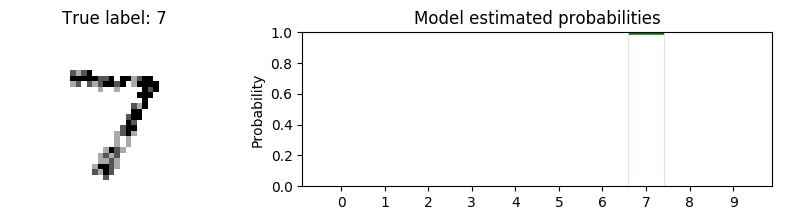

zigzag


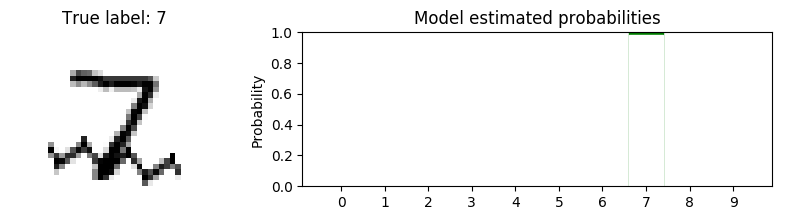

fog


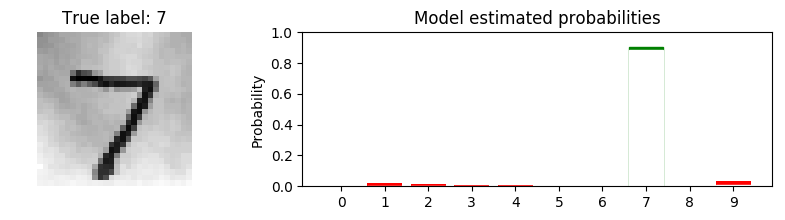

rotate


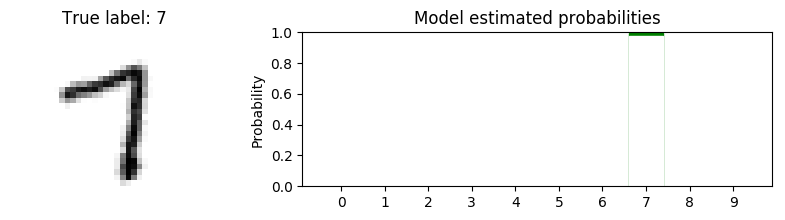

spatter


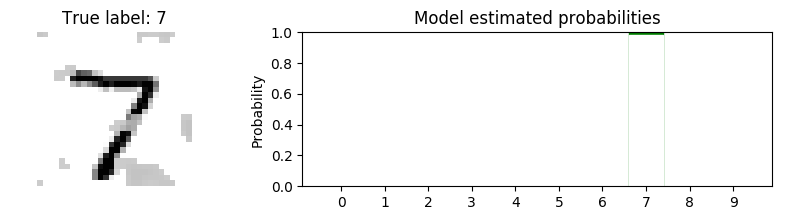

brightness


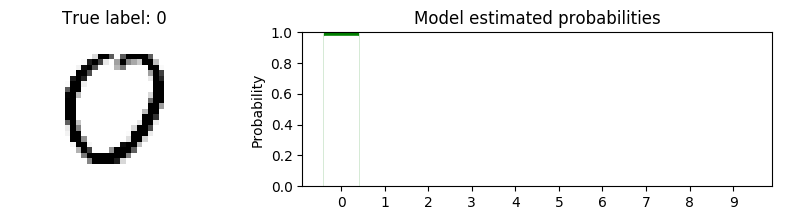

glass_blur


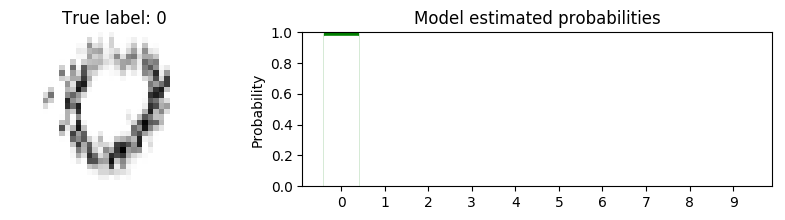

scale


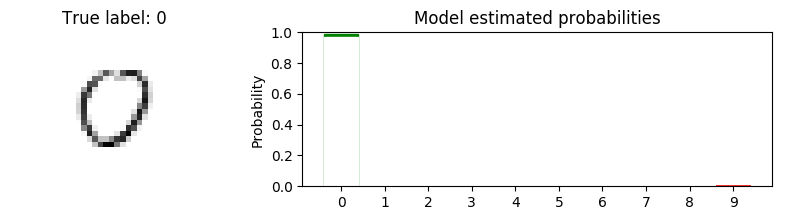

stripe


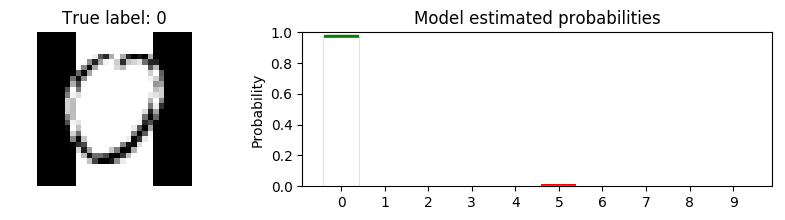

canny_edges


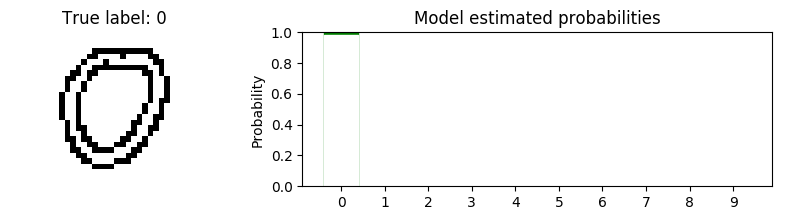

identity


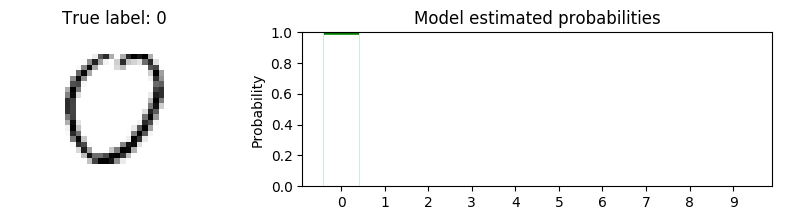

shear


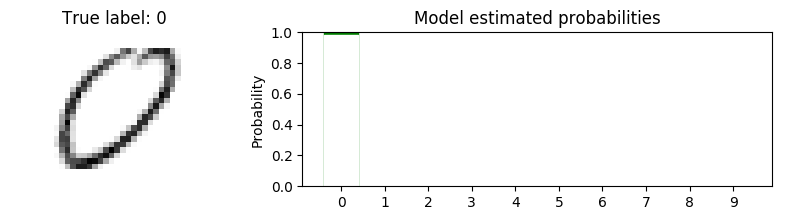

translate


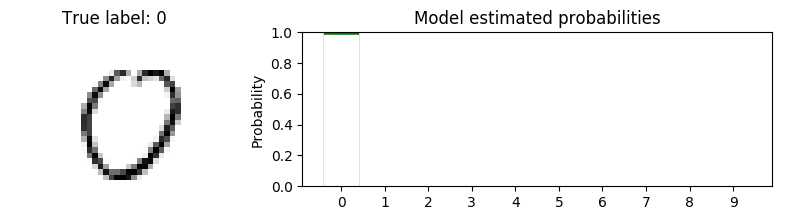

dotted_line


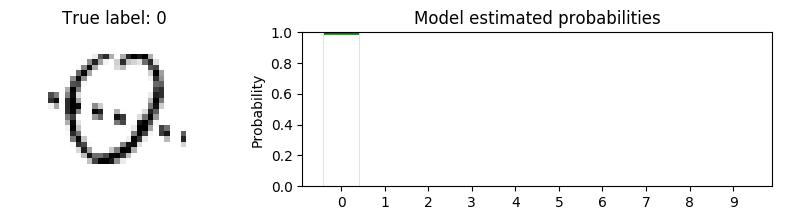

impulse_noise


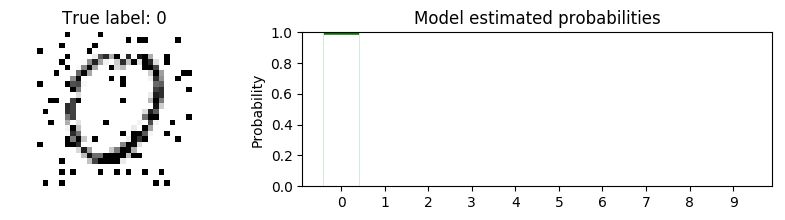

motion_blur


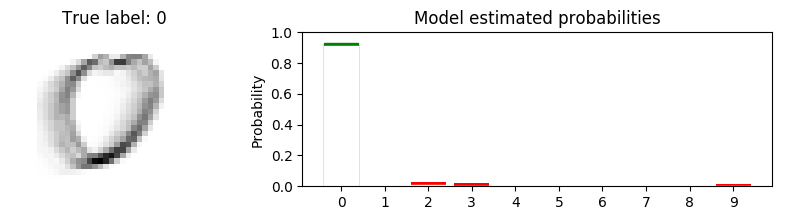

shot_noise


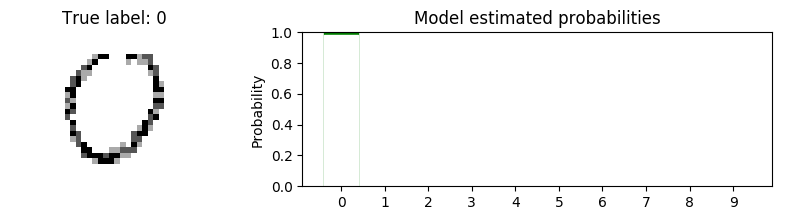

zigzag


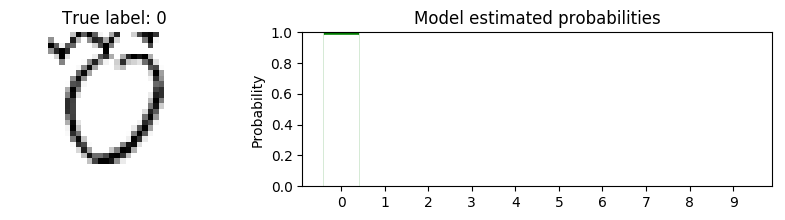

fog


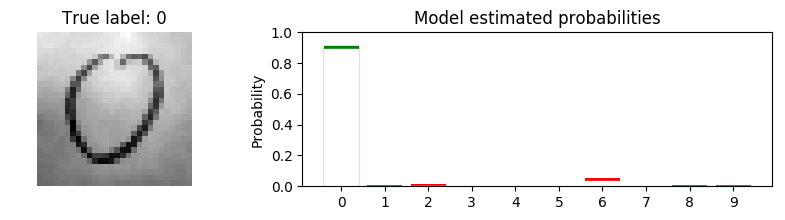

rotate


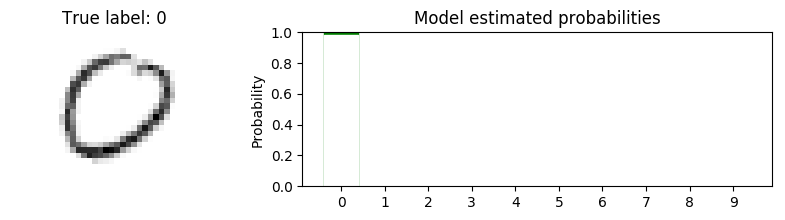

spatter


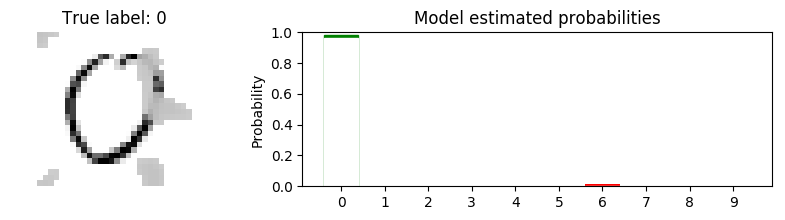

In [63]:
# Prediction examples on MNIST-C

for i in [0, 3710]:
    analyse_model_prediction(x_c_test, y_c_test, probabilistic_model, i)

brightness


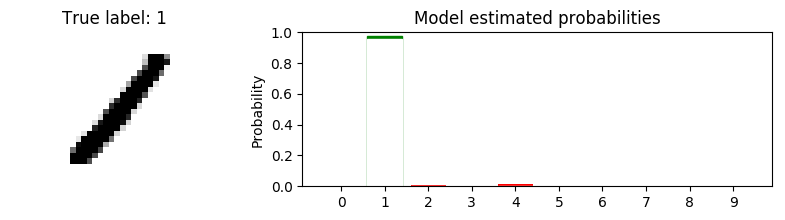

glass_blur


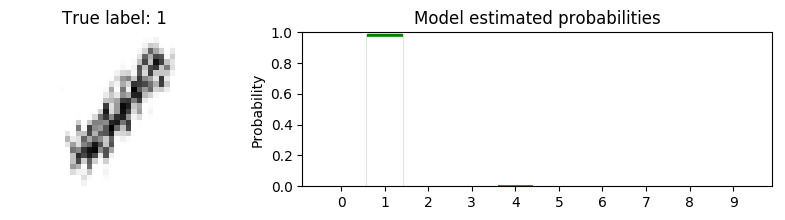

scale


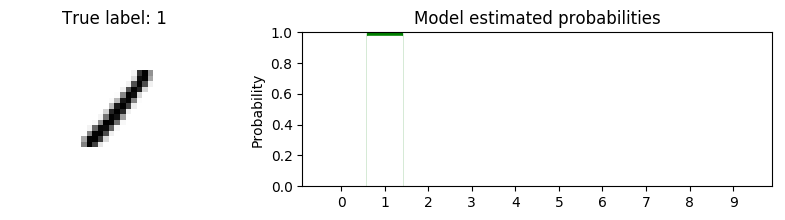

stripe


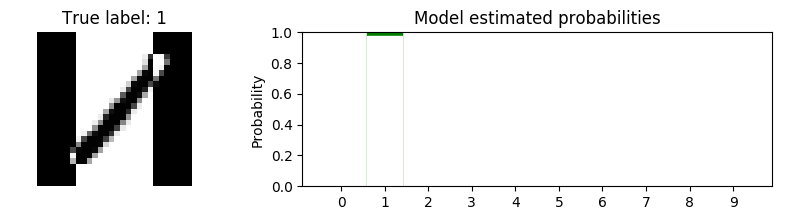

canny_edges


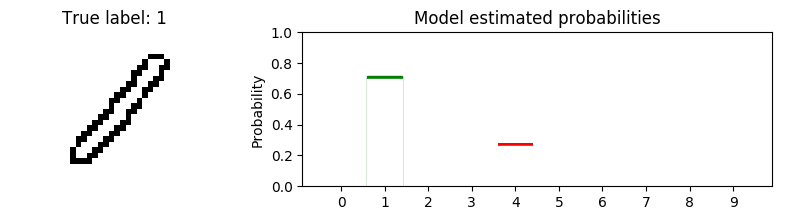

identity


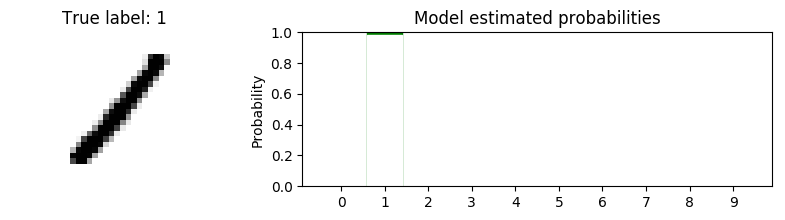

shear


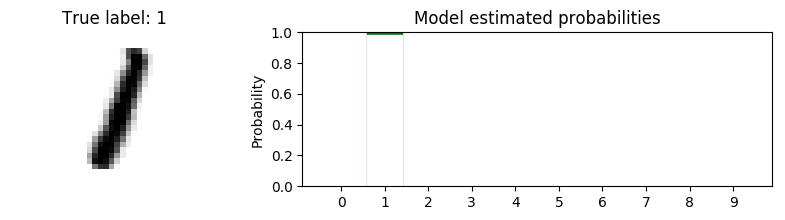

translate


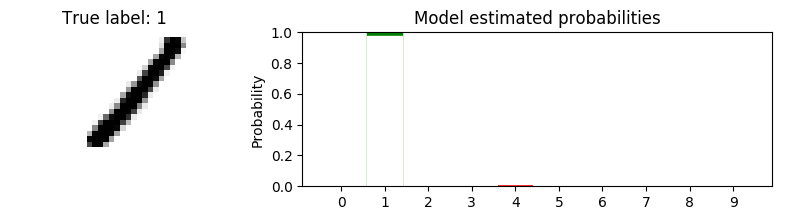

dotted_line


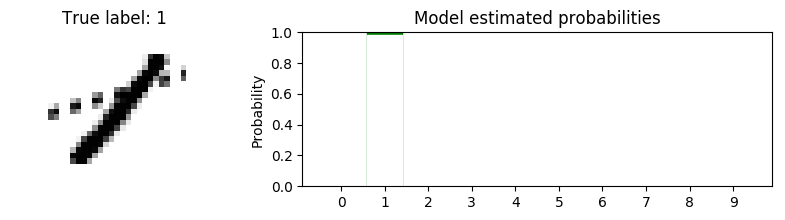

impulse_noise


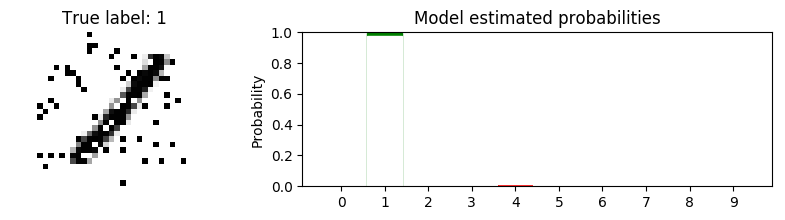

motion_blur


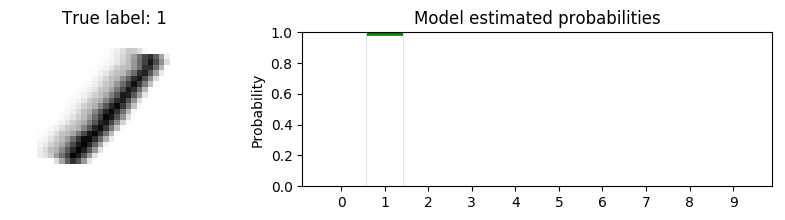

shot_noise


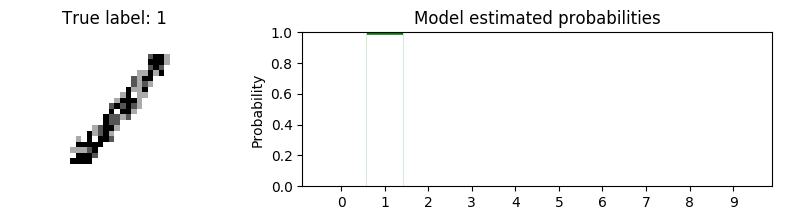

zigzag


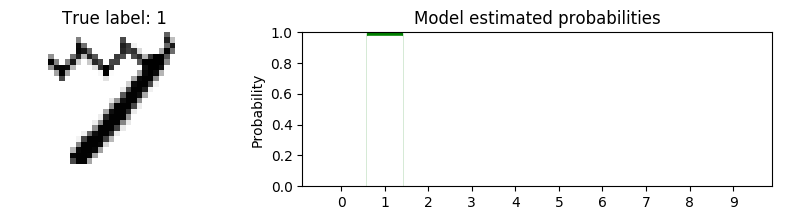

fog


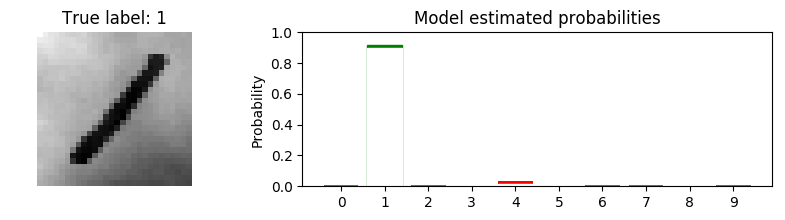

rotate


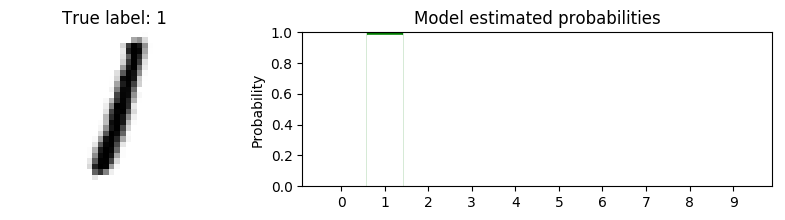

spatter


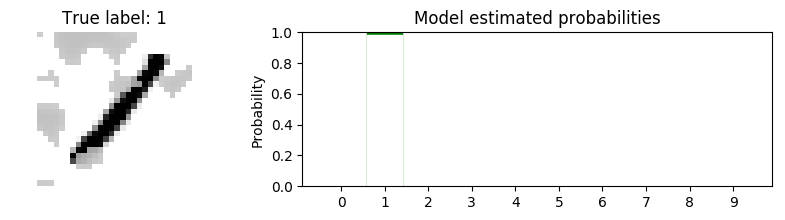

In [64]:
# Prediction examples from both datasets

for i in [9241]:
    analyse_model_prediction(x_c_test, y_c_test, probabilistic_model, i)

It's not surprising what's happening here: the spatters cover up most of the number. You would hope a model indicates that it's unsure here, since there's very little information to go by. This is exactly what's happened.

#### Uncertainty quantification using entropy

We can also make some analysis of the model's uncertainty across the full test set, instead of for individual values. One way to do this is to calculate the [entropy](https://en.wikipedia.org/wiki/Entropy_%28information_theory%29) of the distribution. The entropy is the expected information (or informally, the expected 'surprise') of a random variable, and is a measure of the uncertainty of the random variable. The entropy of the estimated probabilities for sample $i$ is defined as

$$
H_i = -\sum_{j=1}^{10} p_{ij} \text{log}_{2}(p_{ij})
$$

where $p_{ij}$ is the probability that the model assigns to sample $i$ corresponding to label $j$. The entropy as above is measured in _bits_. If the natural logarithm is used instead, the entropy is measured in _nats_.

The key point is that the higher the value, the more unsure the model is. Let's see the distribution of the entropy of the model's predictions across the MNIST and corrupted MNIST test sets. The plots will be split between predictions the model gets correct and incorrect.

In [65]:
# Functions to plot the distribution of the information entropy across samples,
# split into whether the model prediction is correct or incorrect


def get_correct_indices(model, x, labels):
    y_model = model(x)
    correct = np.argmax(y_model.mean(), axis=1) == np.squeeze(labels)
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices


def plot_entropy_distribution(model, x, labels):
    probs = model(x).mean().numpy()
    entropy = -np.sum(probs * np.log2(probs), axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = entropy[get_correct_indices(model, x, labels)[i]]
        mean_entropy = np.mean(entropy_category)
        num_samples = entropy_category.shape[0]
        title = category + 'ly labelled ({:.1f}% of total)'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f} bits'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy (bits)')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
    plt.show()

Corrupted MNIST test set:brightness


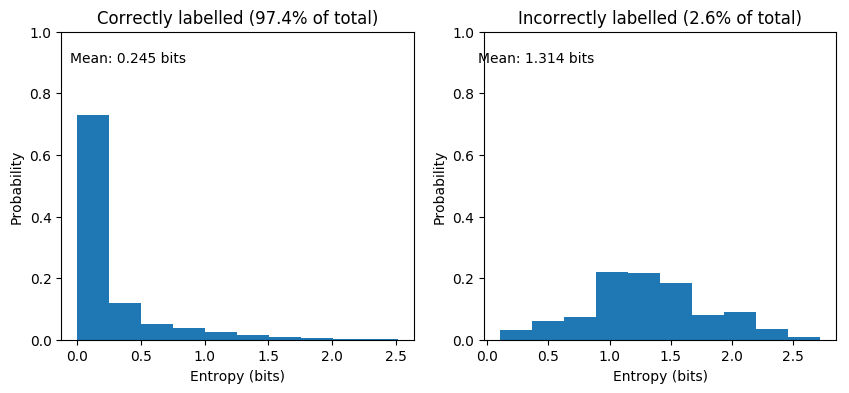

Corrupted MNIST test set:glass_blur


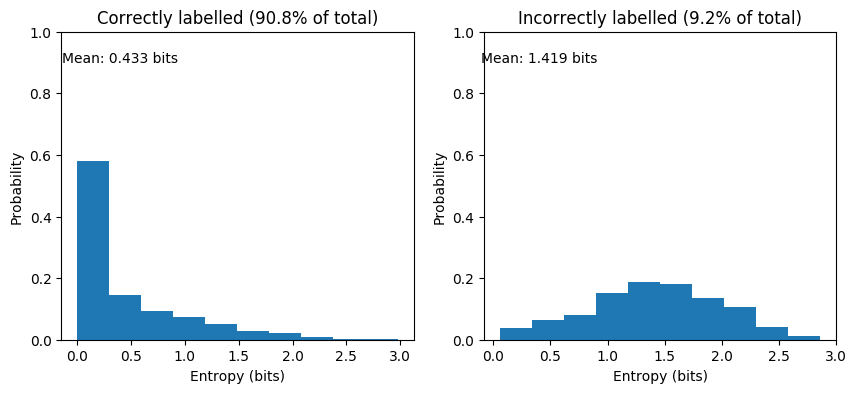

Corrupted MNIST test set:scale


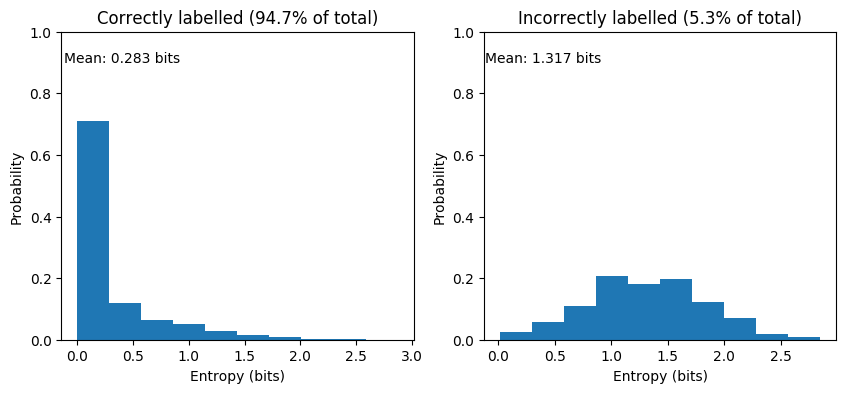

Corrupted MNIST test set:stripe


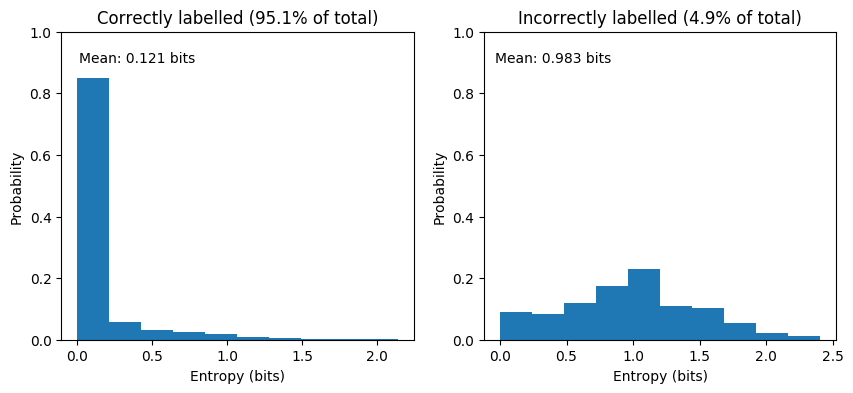

Corrupted MNIST test set:canny_edges


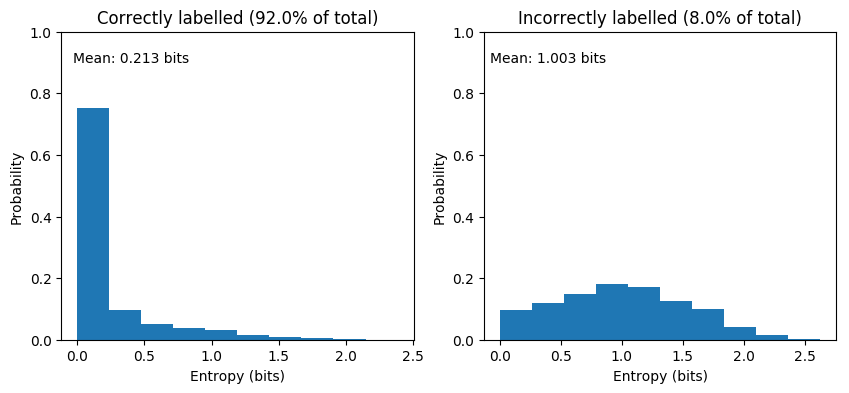

Corrupted MNIST test set:identity


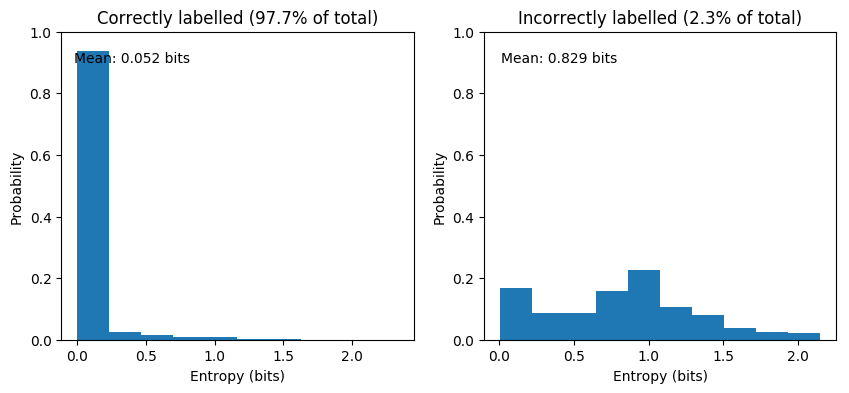

Corrupted MNIST test set:shear


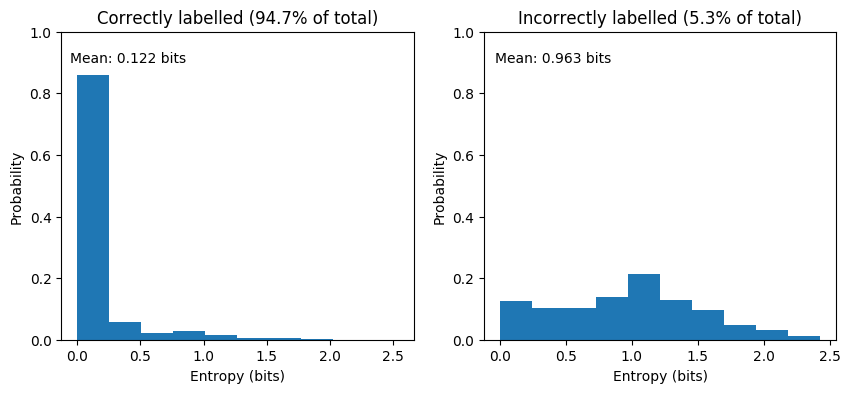

Corrupted MNIST test set:translate


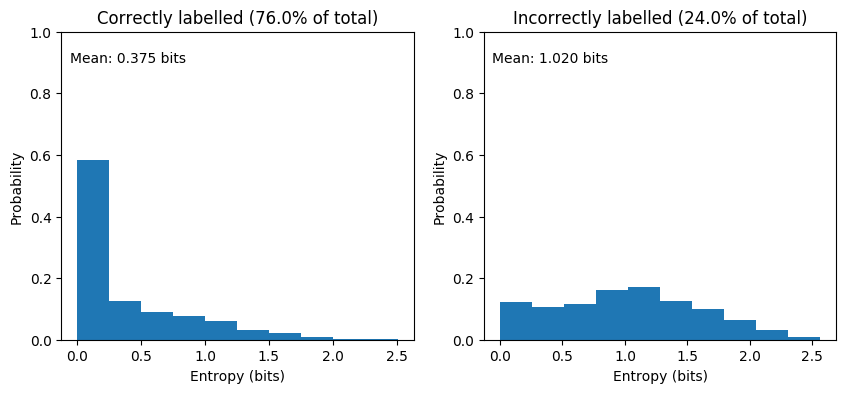

Corrupted MNIST test set:dotted_line


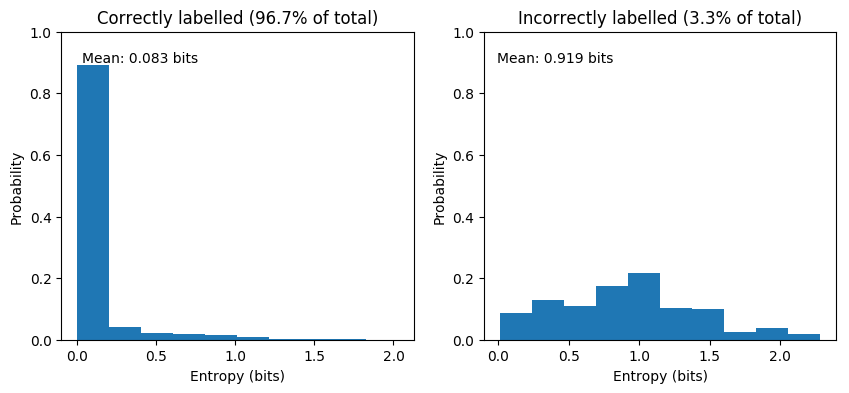

Corrupted MNIST test set:impulse_noise


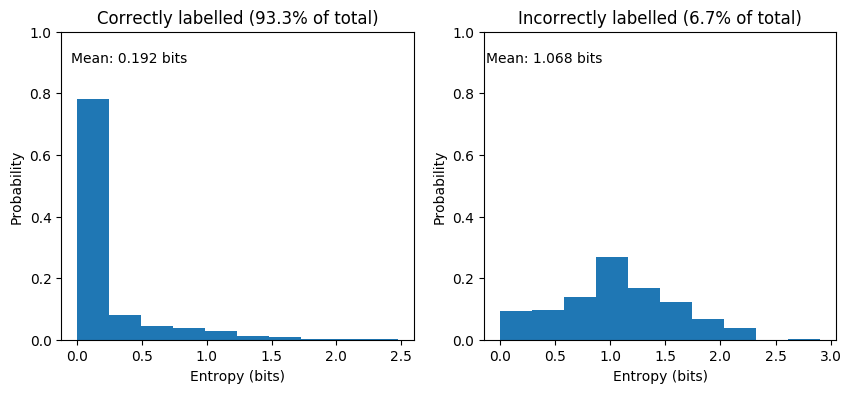

Corrupted MNIST test set:motion_blur


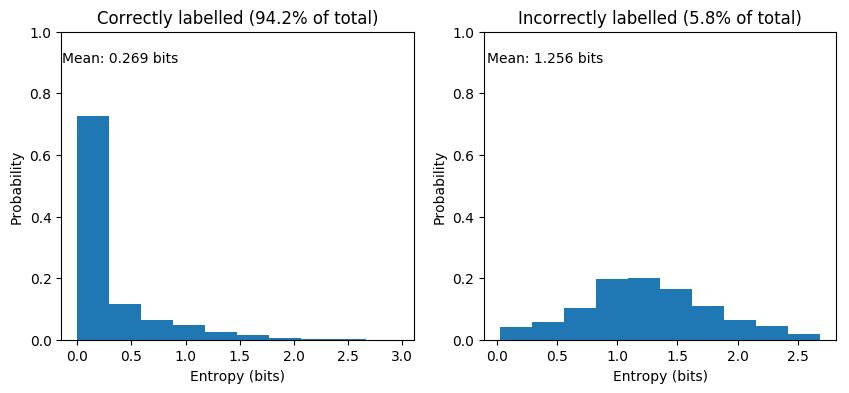

Corrupted MNIST test set:shot_noise


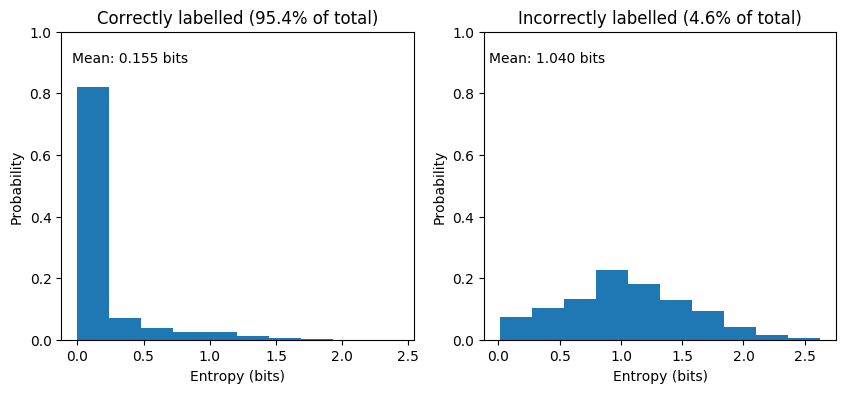

Corrupted MNIST test set:zigzag


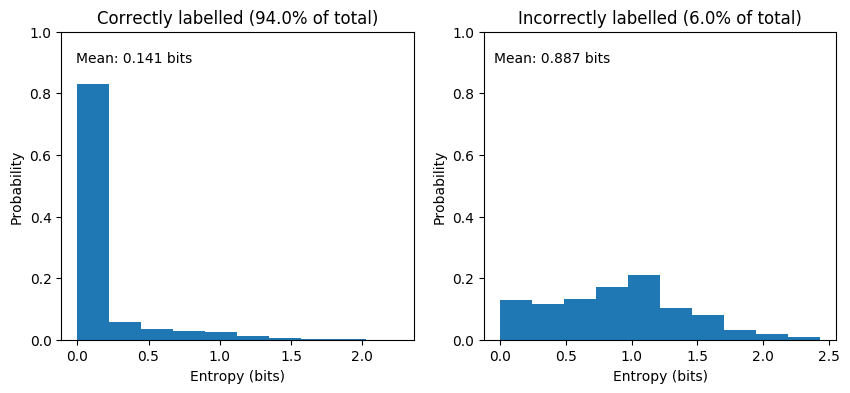

Corrupted MNIST test set:fog


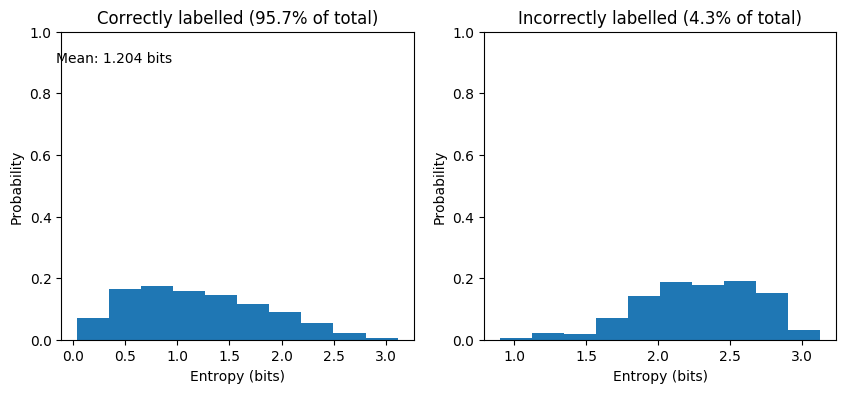

Corrupted MNIST test set:rotate


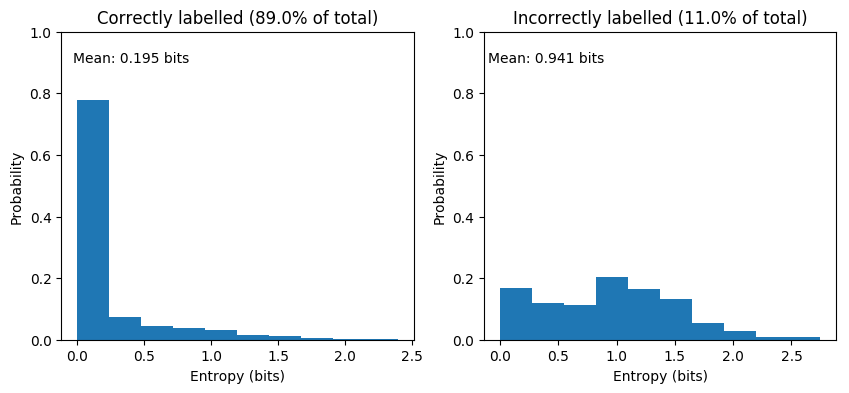

Corrupted MNIST test set:spatter


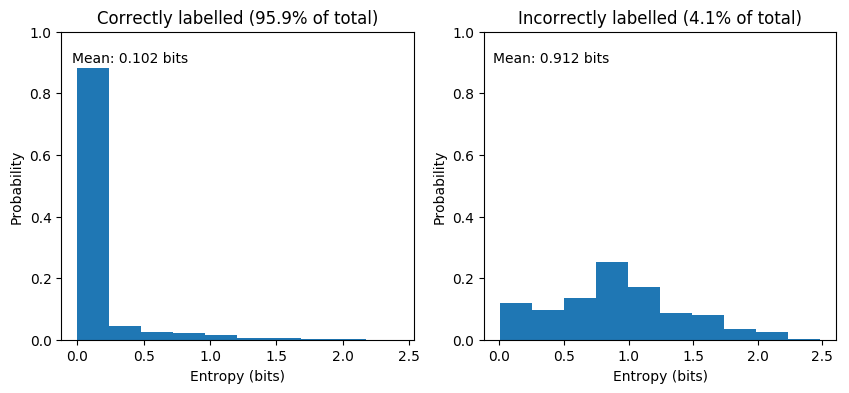

In [66]:
# Entropy plots for the MNIST-C dataset
for mode in corruption_modes:
    print('Corrupted MNIST test set:' + mode)
    plot_entropy_distribution(probabilistic_model, x_c_test[mode], y_c_test[mode])

### Bayesian CNN model

The probabilistic model you just created considered only aleatoric uncertainty, assigning probabilities to each image instead of deterministic labels. The model still had deterministic weights. However, as you've seen, there is also 'epistemic' uncertainty over the weights, due to uncertainty about the parameters that explain the training data. 

You'll now be adding weight uncertainty to the model you just created. Your new model will again have the following layers:
- 2D convolution
- Max pooling
- Flatten
- Dense
- OneHotCategorical

but where the convolutional and dense layers include weight uncertainty. You'll embed weight uncertainty as follows:
- The 2D convolution layer will be replaced by a `Convolution2DReparameterization` layer
- The Dense layer will be replaced by a `DenseVariational` layer.

You should start by creating the convolutional layer in the function below. The function should return an instance of the `Convolution2DReparameterization` layer, according to the following specification: 

* The function takes the `input_shape` and `divergence_fn` as arguments
* The layer should set the input shape in its constructor using the `input_shape` argument
* This layer should have 8 filters, a kernel size of `(5, 5)`, a ReLU activation, and `"VALID"` padding
* The prior for both the kernel and bias should be the standard `default_multivariate_normal_fn`, as seen in the coding tutorial
* The posterior for each parameter in both the kernel and bias should be an independent normal distribution with trainable mean and variance (_hint: use the_ `default_mean_field_normal_fn`_)_
* The divergence function should be set using the `divergence_fn` argument for both the kernel and the bias

_HINT: Review the arguments you used in the coding tutorial on Reparameterization layers._

In [67]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_convolutional_reparameterization_layer(input_shape, divergence_fn):
    """
    This function should create an instance of a Convolution2DReparameterization 
    layer according to the above specification. 
    The function takes the input_shape and divergence_fn as arguments, which should 
    be used to define the layer.
    Your function should then return the layer instance.
    """
    return tfp.layers.Convolution2DReparameterization(input_shape = input_shape, padding='valid', activation='relu', kernel_size=(5,5), filters=8, 
    kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn,
    
                                           )
    

You'll use this function to create your model a little bit later on. 

#### Custom prior

For the parameters of the `DenseVariational` layer, we will use a custom prior: the "spike and slab" (also called a *scale mixture prior*) distribution. This distribution has a density that is the weighted sum of two normally distributed ones: one with a standard deviation of 1 and one with a standard deviation of 10. In this way, it has a sharp spike around 0 (from the normal distribution with standard deviation 1), but is also more spread out towards far away values (from the contribution from the normal distribution with standard deviation 10). The reason for using such a prior is that it is like a standard unit normal, but makes values far away from 0 more likely, allowing the model to explore a larger weight space. Run the code below to create a "spike and slab" distribution and plot its probability density function, compared with a standard unit normal.

In [68]:
# Function to define the spike and slab distribution

def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

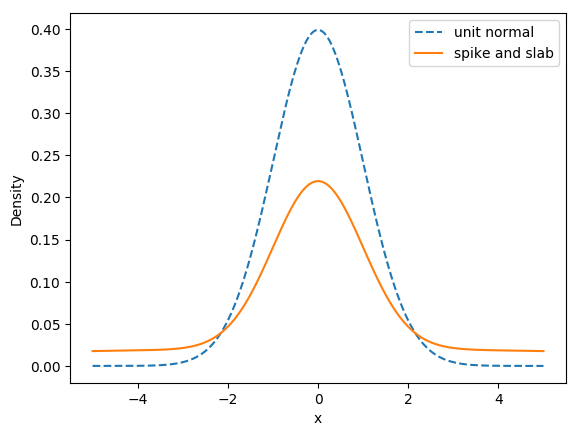

In [69]:
# Plot the spike and slab distribution pdf

x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, spike_and_slab(1, dtype=tf.float32).prob(x_plot).numpy(), label='spike and slab')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

You should now complete the function below to create the prior distribution for the `DenseVariational` layer, using the spike and slab distribution above.

* The function has the required signature for the `make_prior_fn` argument of the `DenseVariational` layer
* The prior will have no trainable parameters
* It should use the spike and slab distribution for both the kernel and the bias, setting the `dtype` according to the function argument
* The distribution should have the correct event shape, according to the `kernel_size` and `bias_size` arguments
* The function should return a callable, that returns the spike and slab distribution

_Hints:_ 
* _Refer to the lecture video and/or coding tutorial to review the_ `DenseVariational` _layer arguments_
* _Use the_ `Sequential` _API with a_ `DistributionLambda` _layer to create the callable that is returned by the function_

In [70]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_prior(kernel_size, bias_size, dtype=None):
    """
    This function should create the prior distribution, consisting of the 
    "spike and slab" distribution that is described above. 
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the prior distribution.
    """
    
    n=kernel_size+bias_size  # event_shape

    prior_model = Sequential([tfpl.DistributionLambda(  lambda       t : spike_and_slab(n, dtype))    ])    

    return prior_model   

You'll use this function when you create the `DenseVariational` layer later on.

You should now complete the function below to create the variational posterior distribution for the `DenseVariational` layer. This distribution will be an independent Gaussian with trainable mean and standard deviation for each parameter in the layer.

* The function has the required signature for the `make_posterior_fn` argument of the `DenseVariational` layer
* The posterior will have 2 trainable variables for each layer parameter, one for the mean and one for the standard deviation
* The distribution should have the correct event shape, according to the `kernel_size` and `bias_size` arguments
* The function should return a callable, that returns the trainable independent Gaussian distribution

_Hints:_ 
* _Refer to the lecture video and/or coding tutorial to review the_ `DenseVariational` _layer arguments_
* _Use the_ `Sequential` _API with a_ `VariableLayer` and an `IndependentNormal` _layer to create the callable that is returned by the function_

In [71]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_posterior(kernel_size, bias_size, dtype=None):
    """
    This function should create the posterior distribution as specified above.
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the posterior distribution.
    """
    n=kernel_size+bias_size  # event_shape

                              
    post_model = Sequential([tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype =dtype) ,
                              tfpl.IndependentNormal(
                                 n
                              )
                              ])    

    return post_model   

You should now use your `prior` and `posterior` functions to complete the function below to create the `DenseVariational` layer. 

* The function has `prior_fn`, `posterior_fn` and `kl_weight` arguments, to be used in the constructor of the `DenseVariational` layer
* The layer should have the correct number of units in order to parameterize a `OneHotCategorical` layer with 10 categories
* The `make_prior_fn`, `make_posterior_fn` and `kl_weight` arguments should be set with the corresponding function arguments
* An exact KL-divergence is unavailable for this choice of prior and posterior, so the layer should not attempt to use an analytical expression for this
* Your function should then return an instance of the `DenseVariational` layer

In [72]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_dense_variational_layer(prior_fn, posterior_fn, kl_weight):
    """
    This function should create an instance of a DenseVariational layer according 
    to the above specification. 
    The function takes the prior_fn, posterior_fn and kl_weight as arguments, which should 
    be used to define the layer.
    Your function should then return the layer instance.
    """
    dl = tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(10),  
        make_posterior_fn = posterior_fn,
        make_prior_fn = prior_fn,
        kl_weight=kl_weight
    ) 

    return dl   
    

Now, you're ready to use the functions you defined to create the convolutional reparameterization and dense variational layers, and use them in your Bayesian convolutional neural network model.

In [73]:
# Create the layers

tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train.shape[0]
convolutional_reparameterization_layer = get_convolutional_reparameterization_layer(
    input_shape=(28, 28, 1), divergence_fn=divergence_fn
)
dense_variational_layer = get_dense_variational_layer(
    get_prior, get_posterior, kl_weight=1/x_train.shape[0]
)

In [74]:
# Build and compile the Bayesian CNN model

bayesian_model = Sequential([
    convolutional_reparameterization_layer,
    MaxPooling2D(pool_size=(6, 6)),
    Flatten(),
    dense_variational_layer,
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])
bayesian_model.compile(loss=nll,
              optimizer=RMSprop(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [75]:
# Print the model summary

bayesian_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization (C (None, 24, 24, 8)         416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_variational (DenseVari (None, 10)                2580      
_________________________________________________________________
one_hot_categorical_2 (OneHo ((None, 10), (None, 10))  0         
Total params: 2,996
Trainable params: 2,996
Non-trainable params: 0
_________________________________________________________________


In [76]:
# Train the model

bayesian_model.fit(x=x_train, y=y_train_oh, epochs=10, verbose=True)

Train on 960000 samples
Epoch 1/10
960000/960000 [==============================] - 67s 70us/sample - loss: 0.7519 - accuracy: 0.7656
Epoch 2/10
960000/960000 [==============================] - 67s 70us/sample - loss: 0.3473 - accuracy: 0.9046
Epoch 3/10
960000/960000 [==============================] - 68s 70us/sample - loss: 0.3107 - accuracy: 0.9152
Epoch 4/10
960000/960000 [==============================] - 68s 71us/sample - loss: 0.2970 - accuracy: 0.9191
Epoch 5/10
960000/960000 [==============================] - 68s 71us/sample - loss: 0.2893 - accuracy: 0.9215
Epoch 6/10
960000/960000 [==============================] - 67s 70us/sample - loss: 0.2848 - accuracy: 0.9225
Epoch 7/10
960000/960000 [==============================] - 68s 71us/sample - loss: 0.2815 - accuracy: 0.9236
Epoch 8/10
960000/960000 [==============================] - 68s 71us/sample - loss: 0.2790 - accuracy: 0.9241
Epoch 9/10
960000/960000 [==============================] - 68s 71us/sample - loss: 0.2765 - acc

In [77]:
# Evaluate the model
 
for mode in corruption_modes:
      print('Accuracy on corrupted MNIST test set: ' + mode,
            str(bayesian_model.evaluate(x_c_test[mode], y_c_test_oh[mode], verbose=False)[1]))

Accuracy on corrupted MNIST test set: brightness 0.9707
Accuracy on corrupted MNIST test set: glass_blur 0.9081
Accuracy on corrupted MNIST test set: scale 0.9442
Accuracy on corrupted MNIST test set: stripe 0.9593
Accuracy on corrupted MNIST test set: canny_edges 0.9175
Accuracy on corrupted MNIST test set: identity 0.9763
Accuracy on corrupted MNIST test set: shear 0.9449
Accuracy on corrupted MNIST test set: translate 0.7477
Accuracy on corrupted MNIST test set: dotted_line 0.9662
Accuracy on corrupted MNIST test set: impulse_noise 0.9343
Accuracy on corrupted MNIST test set: motion_blur 0.9307
Accuracy on corrupted MNIST test set: shot_noise 0.9511
Accuracy on corrupted MNIST test set: zigzag 0.9438
Accuracy on corrupted MNIST test set: fog 0.928
Accuracy on corrupted MNIST test set: rotate 0.8978
Accuracy on corrupted MNIST test set: spatter 0.9575


#### Analyse the model predictions

Now that the model has trained, run the code below to create the same plots as before, starting with an analysis of the predicted probabilities for the same images. 

This model now has weight uncertainty, so running the forward pass multiple times will not generate the same estimated probabilities. For this reason, the estimated probabilities do not have single values. The plots are adjusted to show a 95% prediction interval for the model's estimated probabilities.

brightness


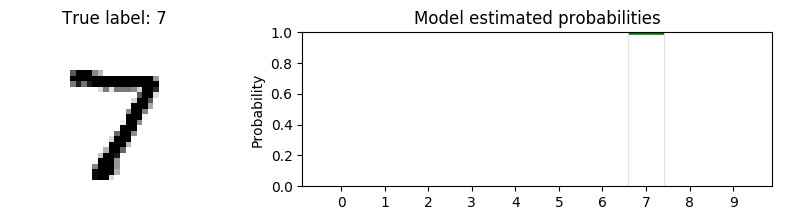

glass_blur


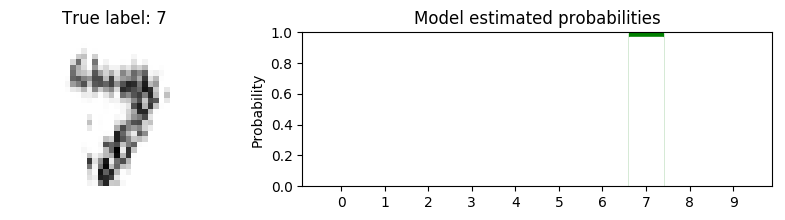

scale


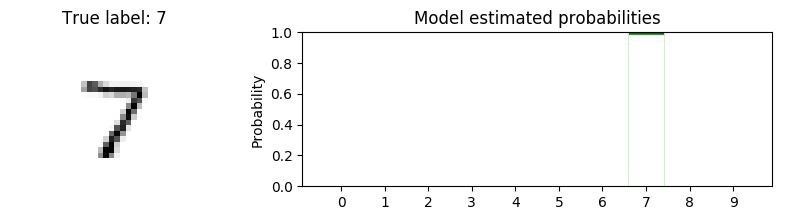

stripe


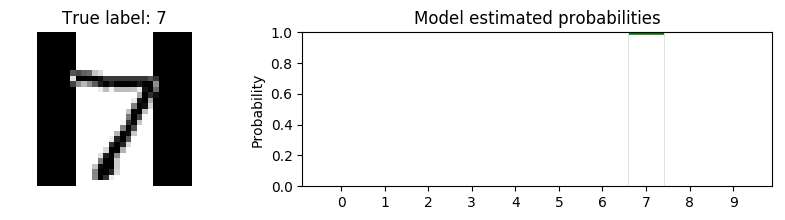

canny_edges


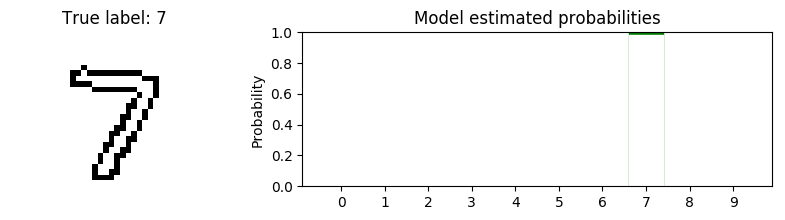

identity


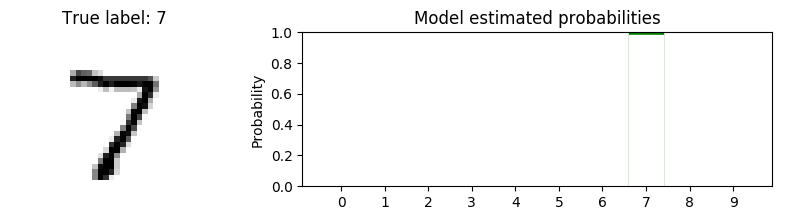

shear


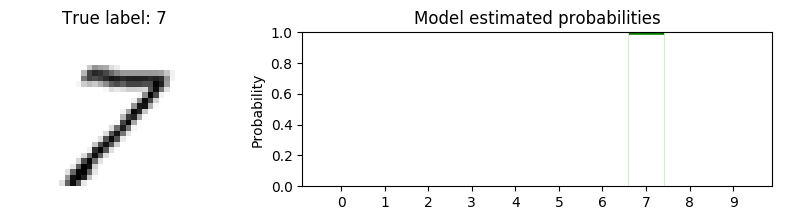

translate


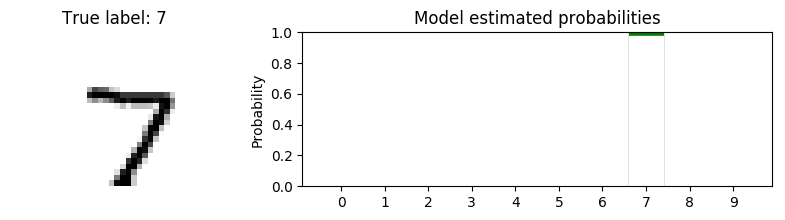

dotted_line


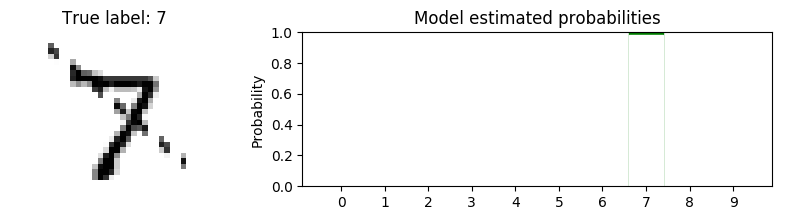

impulse_noise


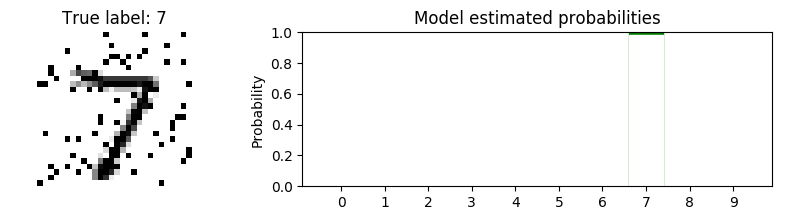

motion_blur


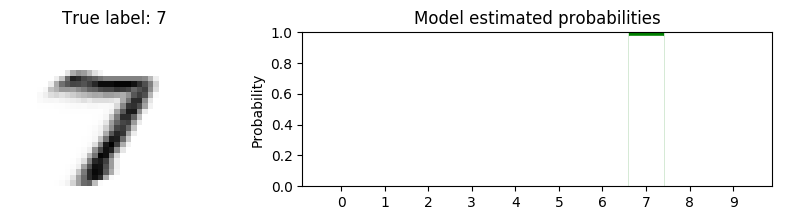

shot_noise


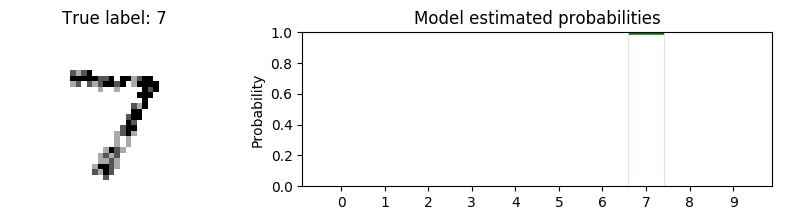

zigzag


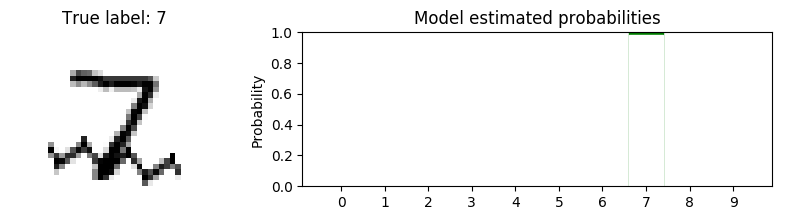

fog


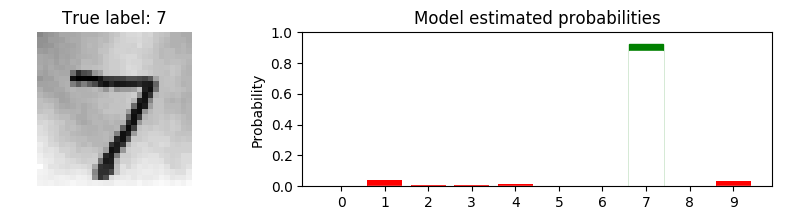

rotate


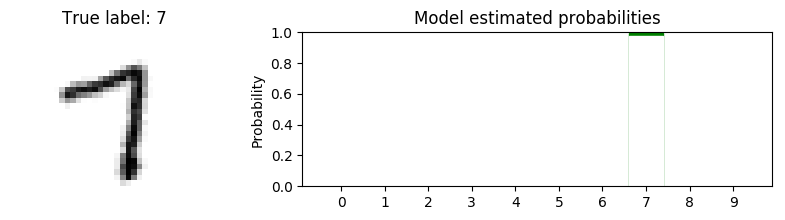

spatter


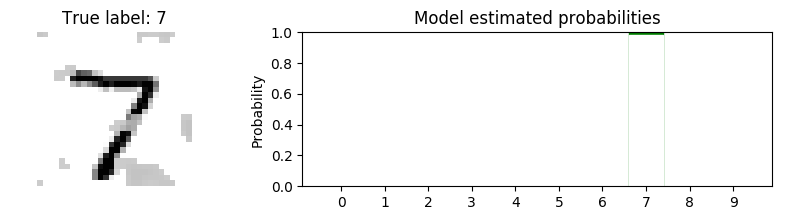

brightness


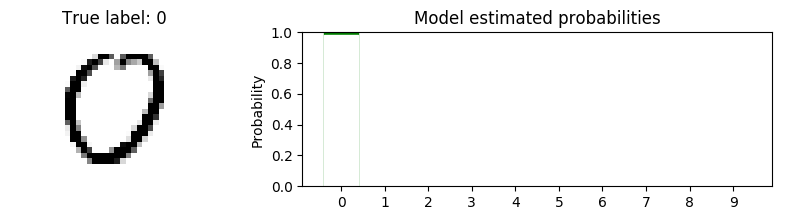

glass_blur


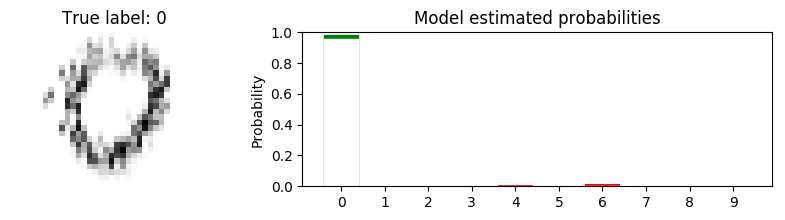

scale


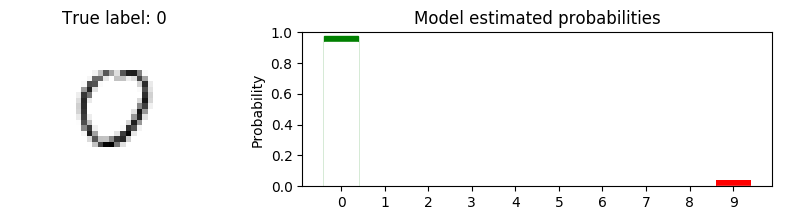

stripe


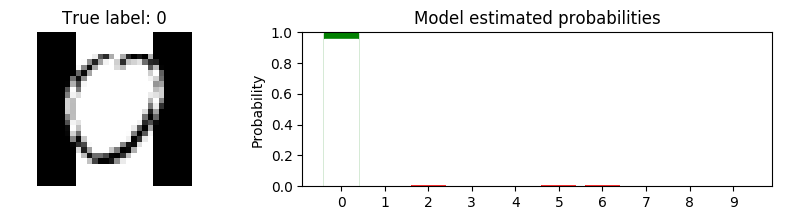

canny_edges


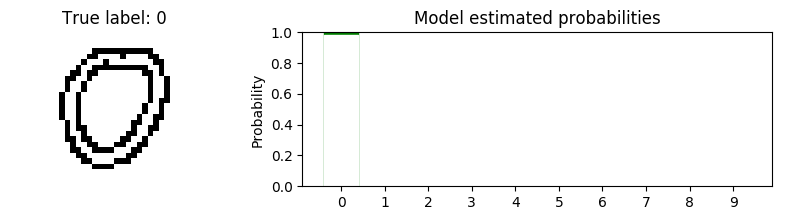

identity


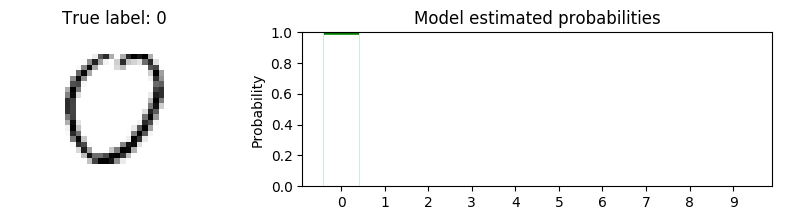

shear


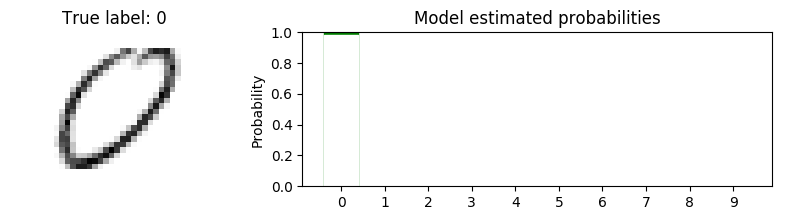

translate


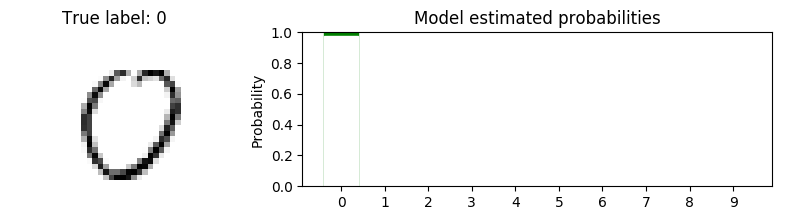

dotted_line


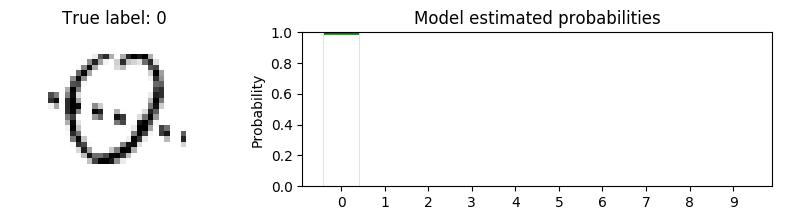

impulse_noise


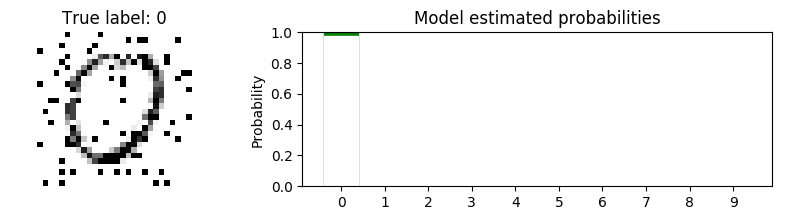

motion_blur


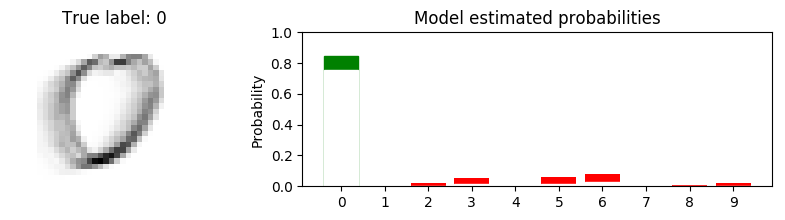

shot_noise


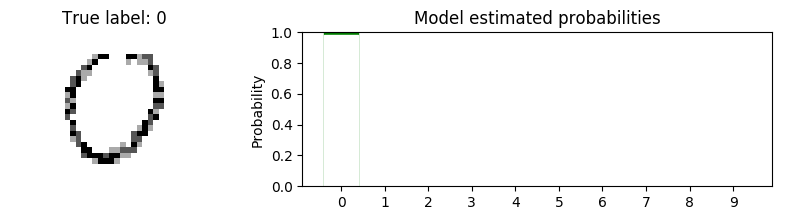

zigzag


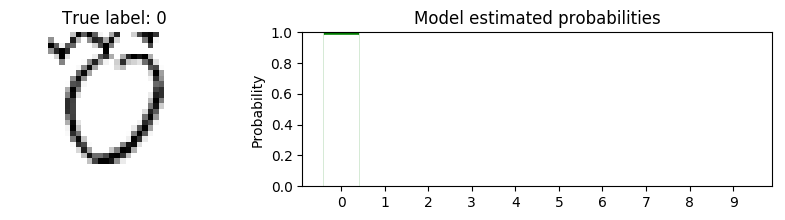

fog


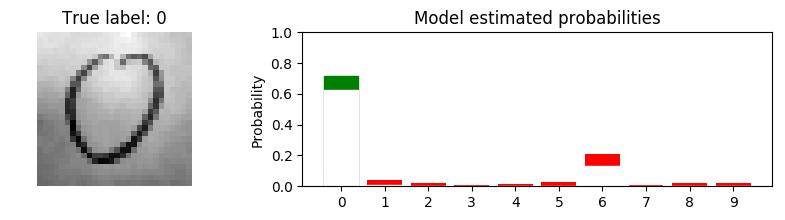

rotate


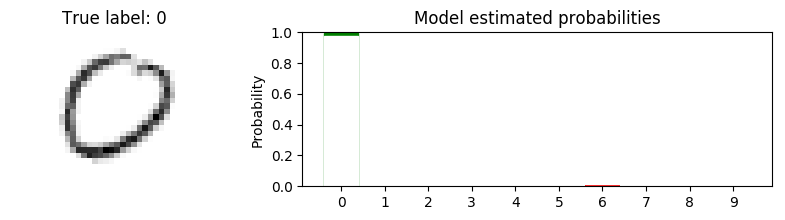

spatter


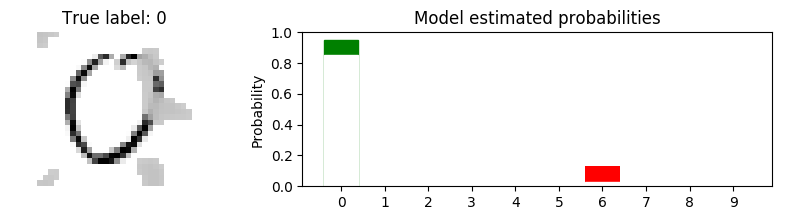

In [78]:
# Prediction examples on MNIST-C

for i in [0, 3710]:
    analyse_model_prediction(x_c_test, y_c_test, bayesian_model, i, run_ensemble=True)

brightness


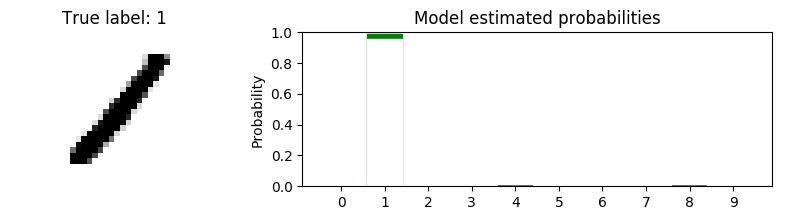

glass_blur


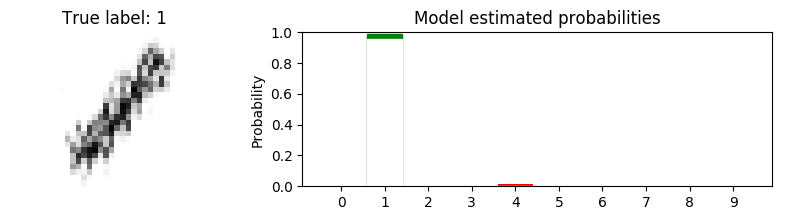

scale


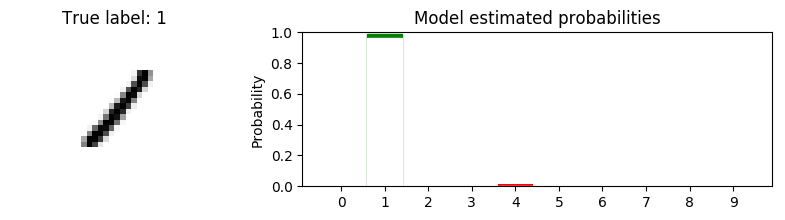

stripe


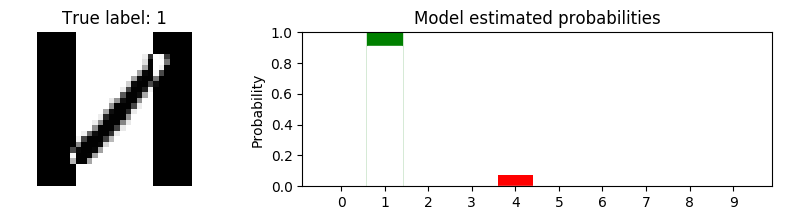

canny_edges


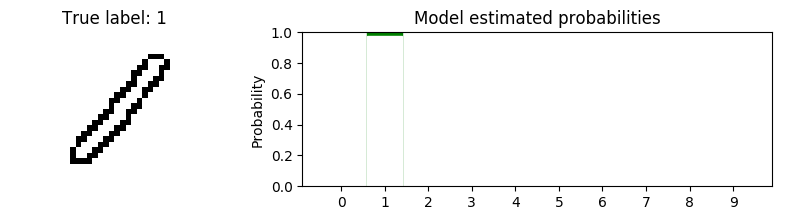

identity


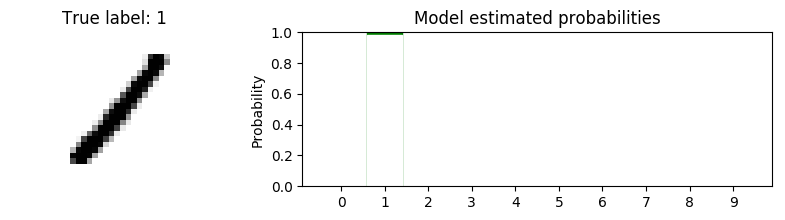

shear


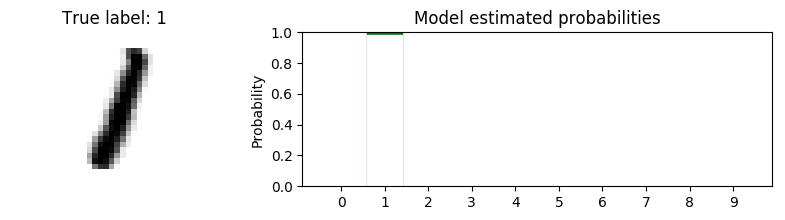

translate


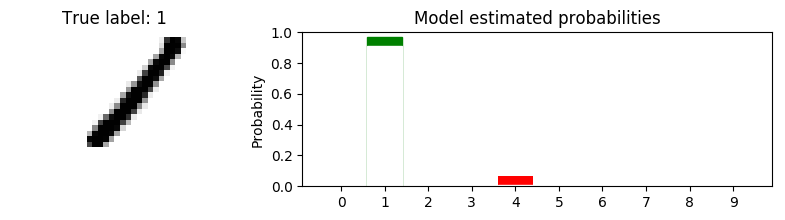

dotted_line


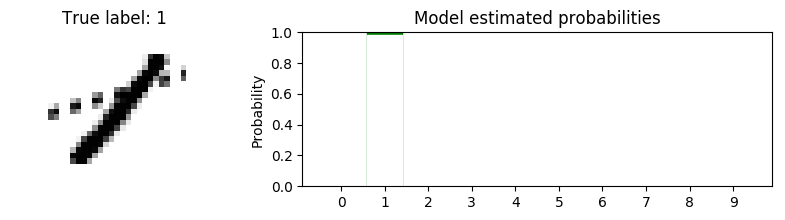

impulse_noise


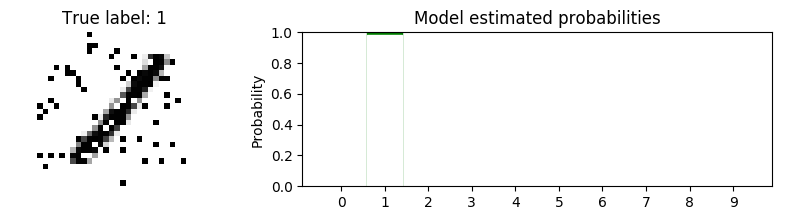

motion_blur


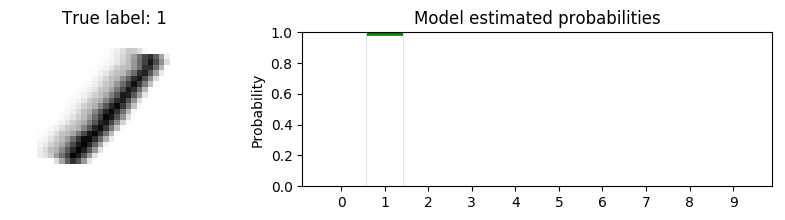

shot_noise


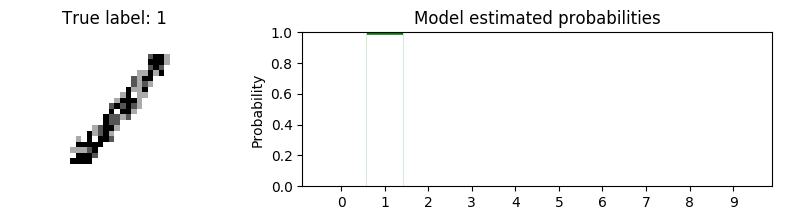

zigzag


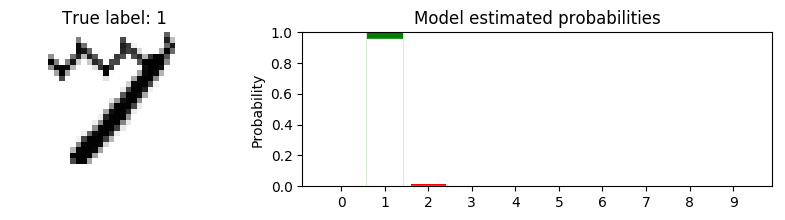

fog


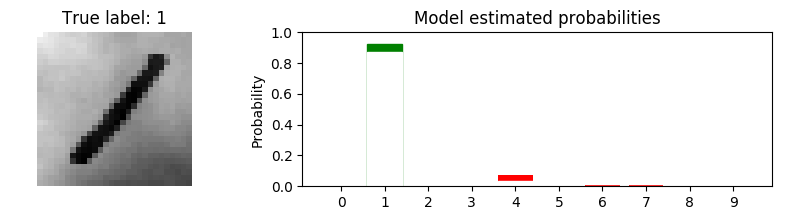

rotate


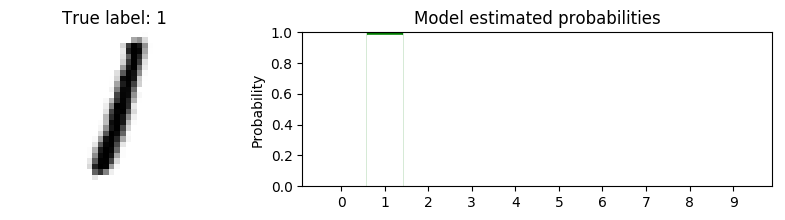

spatter


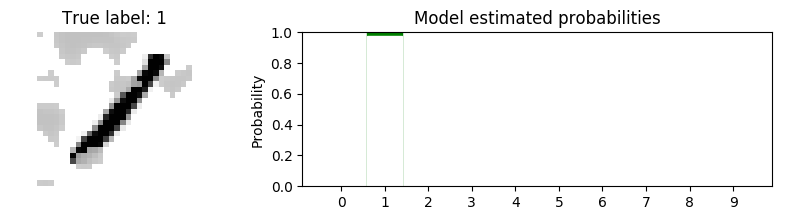

In [79]:
# Prediction examples from both datasets

for i in [9241]:
    analyse_model_prediction(x_c_test, y_c_test, bayesian_model, i, run_ensemble=True)

#### Uncertainty quantification using entropy

We also again plot the distribution of distribution entropy across the different test sets below. In these plots, no consideration has been made for the epistemic uncertainty, and the conclusions are broadly similar to those for the previous model.

Corrupted MNIST test set:brightness


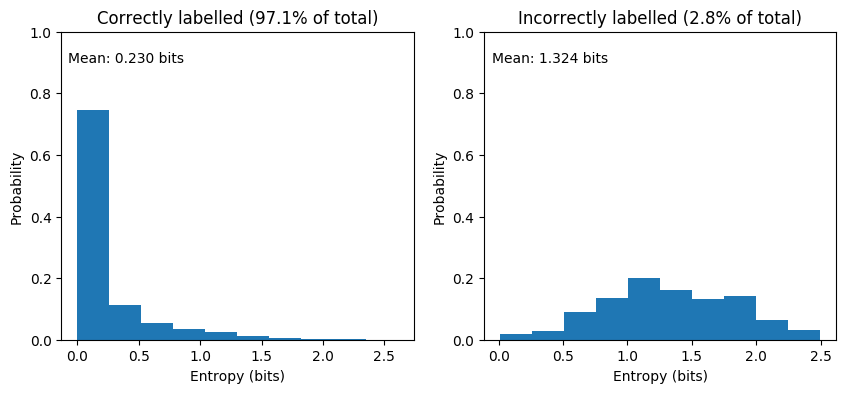

Corrupted MNIST test set:glass_blur


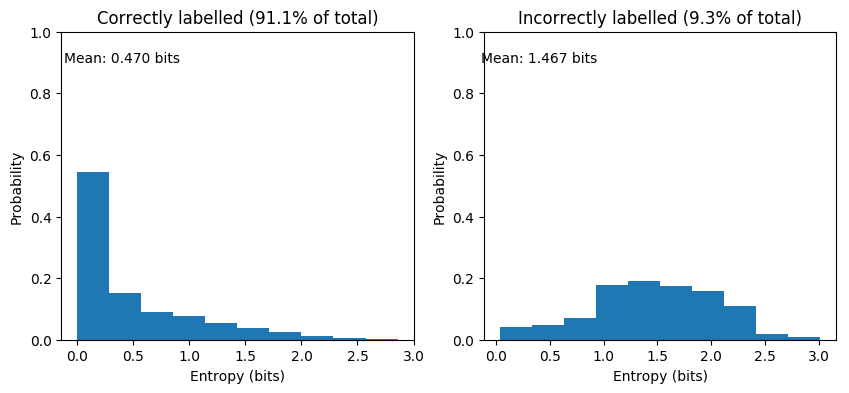

Corrupted MNIST test set:scale


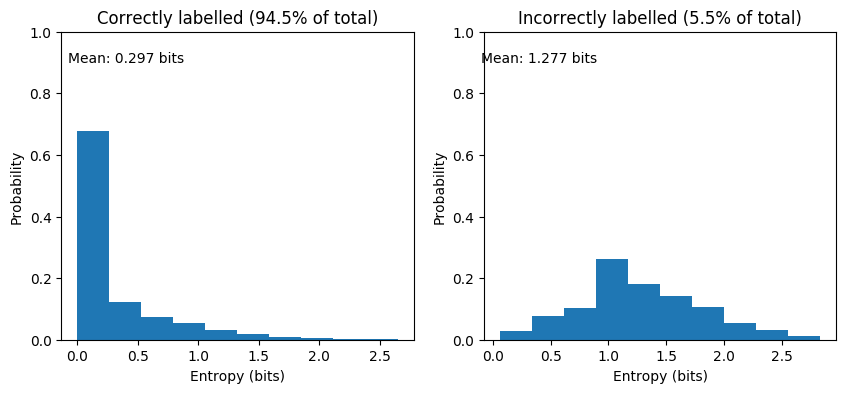

Corrupted MNIST test set:stripe


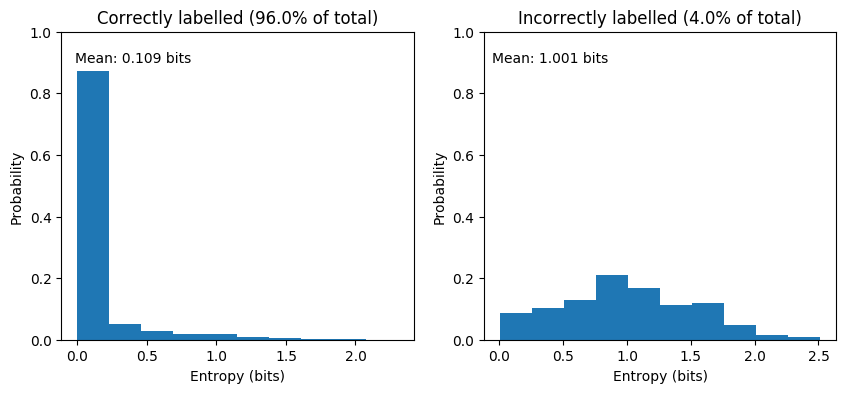

Corrupted MNIST test set:canny_edges


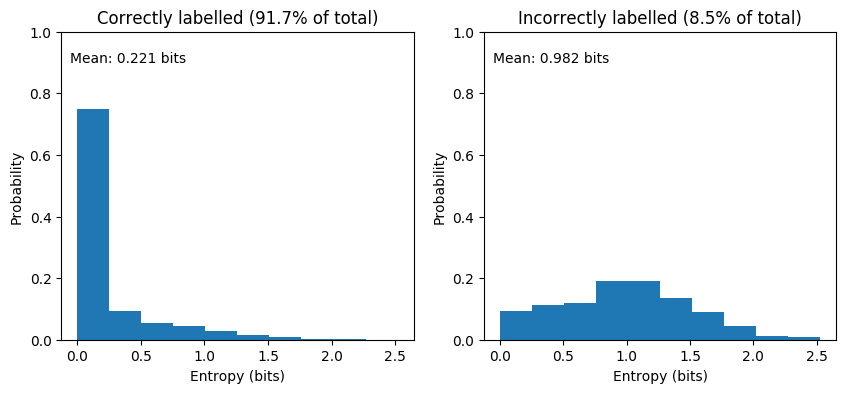

Corrupted MNIST test set:identity


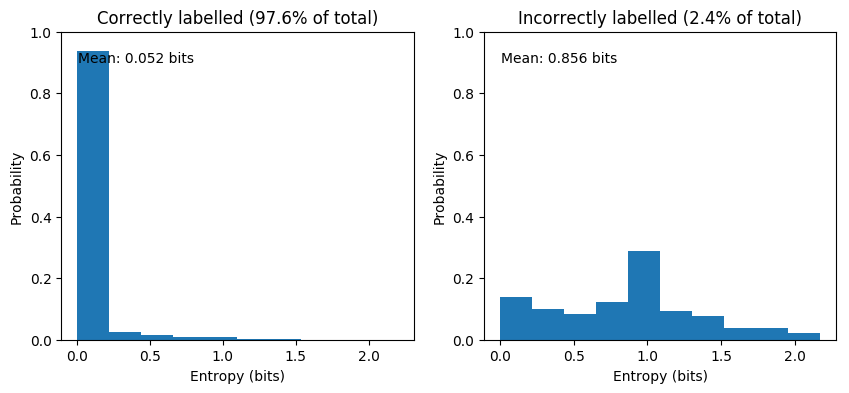

Corrupted MNIST test set:shear


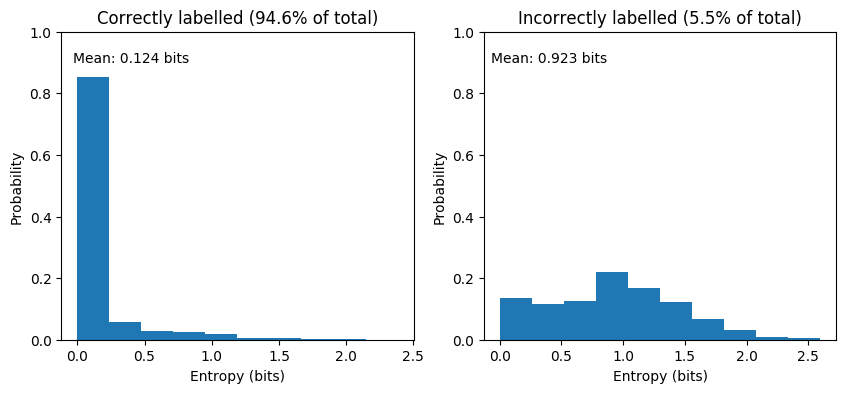

Corrupted MNIST test set:translate


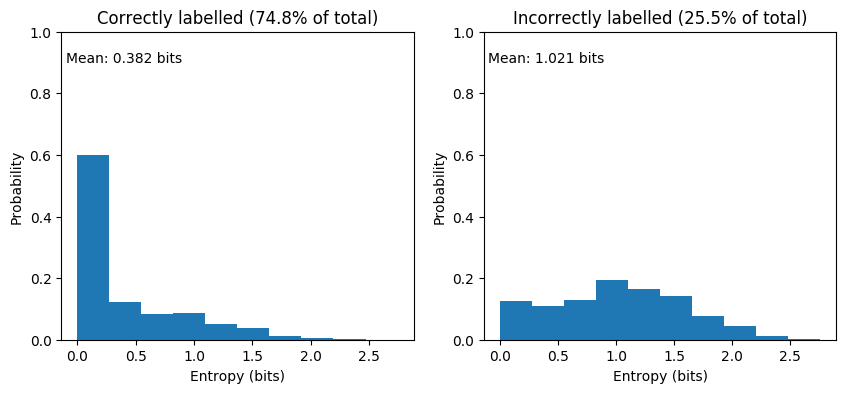

Corrupted MNIST test set:dotted_line


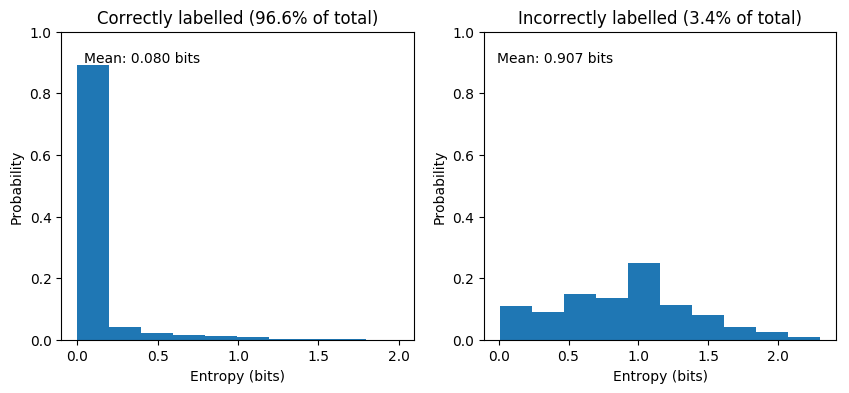

Corrupted MNIST test set:impulse_noise


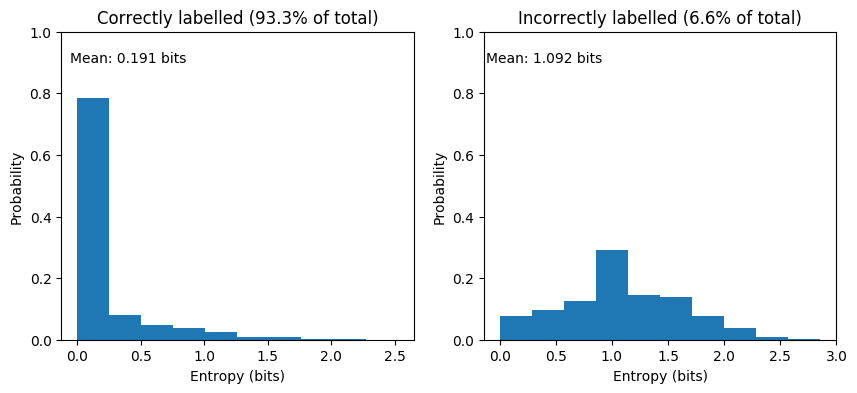

Corrupted MNIST test set:motion_blur


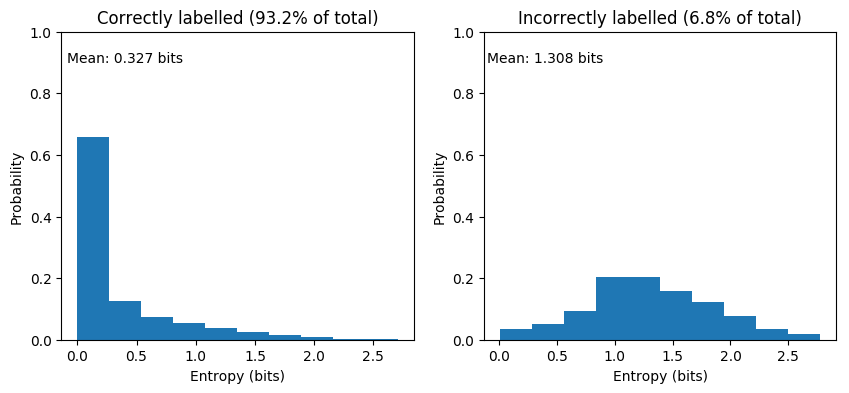

Corrupted MNIST test set:shot_noise


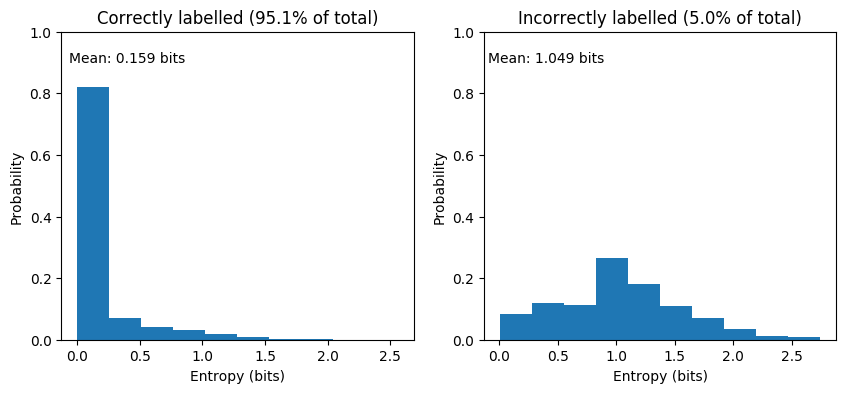

Corrupted MNIST test set:zigzag


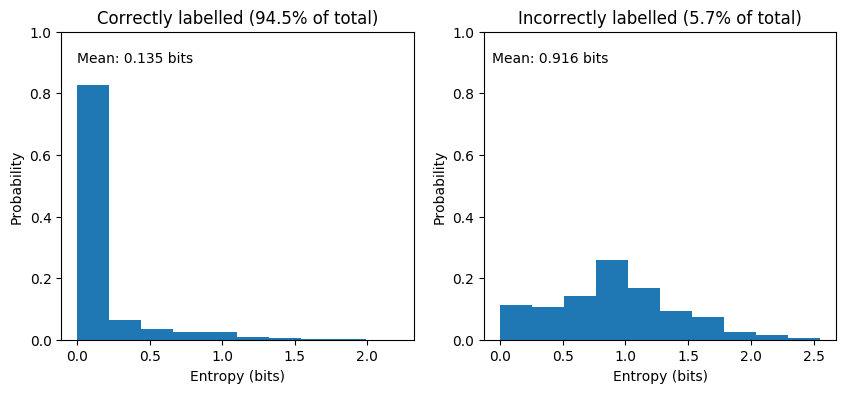

Corrupted MNIST test set:fog


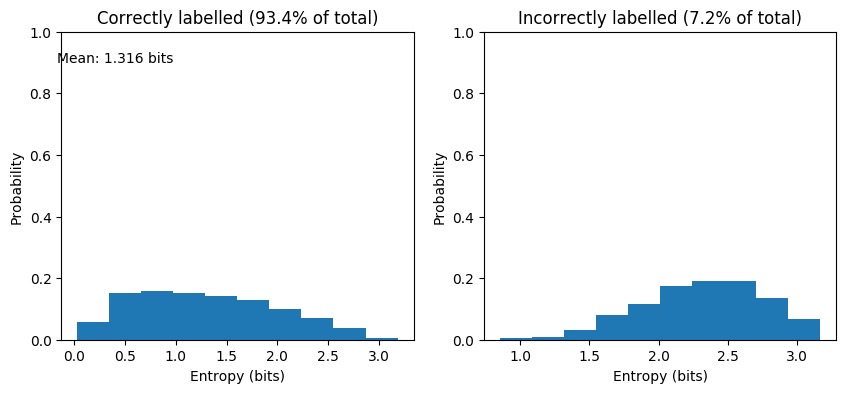

Corrupted MNIST test set:rotate


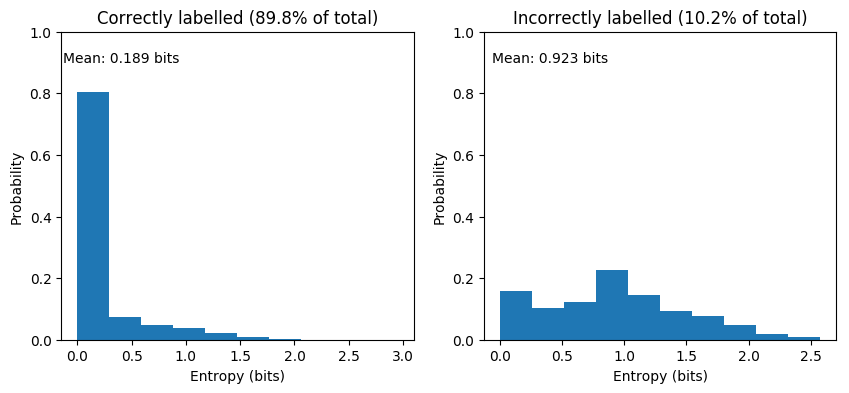

Corrupted MNIST test set:spatter


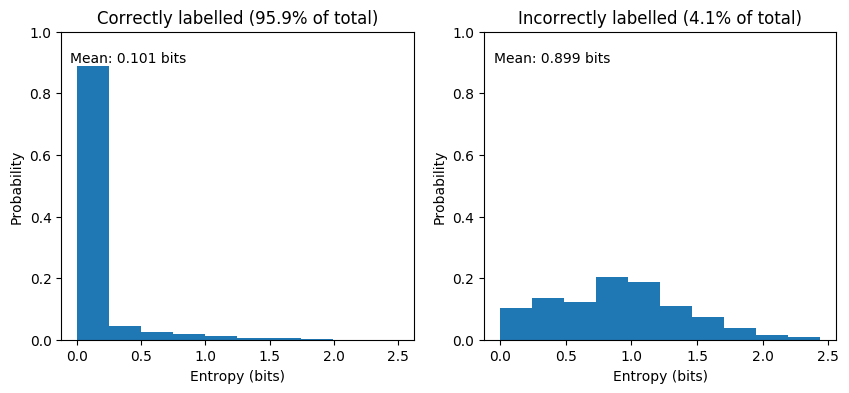

In [80]:
# Entropy plots for the MNIST-C dataset
for mode in corruption_modes:
    print('Corrupted MNIST test set:' + mode)
    plot_entropy_distribution(bayesian_model, x_c_test[mode], y_c_test[mode])

TODO - data set generator, batch size, Fashion MNIST-c, different functions for prior/posterior. Data Augmentation using code vs images? (More randomness on the fly?) 

Using validation dataset to guide during the train (early termination)

Although Bayesian model has twice more # parameters, the training time was similar.

The score for Bayesian model is equivalent to the probablistic model. (Dissappointing)

The benefit using Bayesian model is outweighed by using augmentation.

The fog dataset has peculiar entropy shape - blurred and high